# Introduction

Hi! This is my first public notebook shared on Kaggle! 😊 I know there are already many impressive notebooks in this dataset, featuring advanced analysis and machine learning models. While mine may not be as sophisticated, I’d like to share my approach to solving a real-world problem using data analysis and logical thinking.

As someone passionate about technology, I enjoy watching tech and gadget reviews including those for smartphones. Lately, the market has been flooded with new phones, even from smaller brands, making it harder to keep up. Watching multiple reviews takes time, and most people don’t have the patience (or interest) to do so. Often, my parents or friends ask me for advice on which phone to buy. Honestly? I didn’t always have a good answer. I’d usually start by asking about their budget, then spend time watching reviews before making suggestions.

>That got me thinking: What if we could make smarter phone recommendations using data instead of relying solely on video reviews?

In this notebook, I’ll analyze smartphone specifications and prices to help simplify the decision-making process. Instead of watching hours of videos, we can use insights from the data to find the best options based on what matters most like performance, features, and budget.

Let’s dive in!

# Load Library & Data 

Nothing fancy here, it's just loading some useful libraries and the data itself!

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import pearsonr, spearmanr, kruskal, f_oneway
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

plt.style.use('ggplot')

In [3]:
df = pd.read_csv("../data/Mobiles Dataset (2025).csv", encoding="unicode_escape")
df.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 224,999","INR 79,999","CNY 5,799",USD 799,"AED 2,799",2024
1,Apple,iPhone 16 256GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 234,999","INR 84,999","CNY 6,099",USD 849,"AED 2,999",2024
2,Apple,iPhone 16 512GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 244,999","INR 89,999","CNY 6,499",USD 899,"AED 3,199",2024
3,Apple,iPhone 16 Plus 128GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 249,999","INR 89,999","CNY 6,199",USD 899,"AED 3,199",2024
4,Apple,iPhone 16 Plus 256GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 259,999","INR 94,999","CNY 6,499",USD 949,"AED 3,399",2024


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               930 non-null    object
 1   Model Name                 930 non-null    object
 2   Mobile Weight              930 non-null    object
 3   RAM                        930 non-null    object
 4   Front Camera               930 non-null    object
 5   Back Camera                930 non-null    object
 6   Processor                  930 non-null    object
 7   Battery Capacity           930 non-null    object
 8   Screen Size                930 non-null    object
 9   Launched Price (Pakistan)  930 non-null    object
 10  Launched Price (India)     930 non-null    object
 11  Launched Price (China)     930 non-null    object
 12  Launched Price (USA)       930 non-null    object
 13  Launched Price (Dubai)     930 non-null    object
 14  Launched Y

# Data Cleaning & Preprocessing

You’ll notice that the dataset is already quite tidy there are no missing (null) values, which saves us significant time on data cleaning. However, nearly all columns are of type object (i.e., strings), except for `Launched Year`, which is already numeric. To perform meaningful numerical analysis, we need to convert relevant columns to appropriate numeric types (int or float) by extracting useful information from the text.

For example, a RAM value like "6GB" should be converted to the number 6. To prepare the data for analysis, we’ll carry out the following preprocessing steps:

1. Standardize column names: Replace spaces and special characters with underscores (e.g., Model Name --> model_name) for consistency and easier access during analysis.
2. Convert string values to lowercase: Ensures uniformity and avoids case-sensitive mismatches.
3. Extract components from Model Name:
   - Phone brand/model (e.g., iPhone)
   - Series/variant (e.g., 16)
   - Internal storage (e.g., extract 128 from 128GB)
4. Extract screen size (in inches) from display-related fields.
5. Extract RAM (in GB) by removing "GB" and converting to numeric.
6. Extract battery capacity (in mAh) from the battery description.
7. Extract front and rear camera specifications.
8. Parse processor details from the Processor column:
   - Processor brand (e.g., Snapdragon)
   - Processor series/model (e.g., "8 Gen 2" from "Snapdragon 8 Gen 2")
   - Convert internal memory to GB : Standardize units so that values like 1TB become 1024, ensuring consistency across devices.
9. Unify processor naming: Since Qualcomm and Snapdragon (same with Mediatek, Helio, and Dimensity) refer to the same chipset family, we’ll standardize them under a single name (e.g., Snapdragon) for clarity.
10. Cast columns to appropriate data types: Convert extracted numeric features (RAM, storage, screen size, etc.) to int or float for analysis.

These steps will transform the raw, text-heavy dataset into a clean, structured format ready for exploratory analysis and insights.

In [5]:
def standardize_col_names(df):
    col_names = df.columns.values
    for idx, col in enumerate(col_names):
        col_names[idx] = "_".join([word for word in col.lower().replace("(", "").replace(")", "").split(" ")])
    df.columns = col_names

    return df

def lowercase_string_cols(df):
    for col in df.columns:
        if df[col].dtypes == "object":
            df[col] = df[col].str.lower()

    return df

def extract_launched_price(df):
    for col in df.columns:
        if col.startswith("launched_price"):
            df[col] = df[col].str.replace(",", "")
            df[col] = df[col].str.extract(r'(\d+)$')
            
    return df

def extract_screen_size(df):
    df["screen_size"] = df['screen_size'].str.extract(r"(\d+\.?\d*)")
    return df

def extract_battery_capacity(df):
    df["battery_capacity"] = df["battery_capacity"].str.replace(",", "")
    df["battery_capacity"] = df["battery_capacity"].str.replace("mah", "")
    return df

def sum_back_camera_resolutions(s):
        nums = s.str.extractall(r'(\d+)mp')[0].astype(float)
        return nums.groupby(level=0).sum()

def extract_camera_reso(df):
    df["front_camera"] = df["front_camera"].str.extract("(\d+)mp")
    df["back_camera"] = sum_back_camera_resolutions(df["back_camera"]) # Some phones have multiple back cameras. In this case, we can just sum them up
    return df

def extract_ram(df):
    df["ram"] = df["ram"].str.replace("gb", "")
    df["ram"] = df['ram'].str.split('/').str[-1].str.strip()
    
    return df

def extract_weight(df):
    df["mobile_weight"] = df["mobile_weight"].str.replace("g", "")
    return df

def extract_features_from_model_name(df):
    df = extract_launched_price(df)
    df = extract_screen_size(df)
    df = extract_battery_capacity(df)
    df = extract_camera_reso(df)
    df = extract_ram(df)
    df = extract_weight(df)
    df = df.drop("model_name", axis=1)
    
    return df

def split_model_series_rom(df):
    df["model_name"] = df["model_name"].str.split()
    df["model"] = df["model_name"].str[0]
    df["internal_memory"] = df["model_name"].str[-1]
    df['internal_memory'] = np.where(df['internal_memory'].str.contains('gb|tb', na=False), df['internal_memory'], np.nan)
    df["internal_memory"] = df["internal_memory"].str.extract(r"(\d+)[gb|tb]")
    df["series"] = np.where(df["internal_memory"].isnull(), df["model_name"].str[1:].str.join(" "), df["model_name"].str[1:-1].str.join(' '))

    return df

def extract_features_from_processor(df):
    df["processor"] = df["processor"].str.split()
    df["processor_name"] = df["processor"].str[0]
    df["processor_type"] = df["processor"].str[1:].str.join(" ")
    df = df.drop("processor", axis=1)

    return df

def normalize_processor_names(df):
    df["processor_type"] = np.where(df["processor_name"]=="snapdragon", "snapdragon " + df["processor_type"], df["processor_type"])
    df["processor_name"] = np.where(df["processor_name"]=="snapdragon", "qualcomm", df["processor_name"])
    df["processor_name"] = np.where(df["processor_name"].isin(["dimensity", "helio"]), "mediatek", df["processor_name"])

    return df

def normalize_processor_types(df):
    processor_name_list = df["processor_name"].unique().tolist()
    df["processor_type"] = np.where(df["processor_name"].str.split().str[0].isin(processor_name_list), 
                                    "snapdragon " + df["processor_type"], 
                                    df["processor_type"])

def convert_internal_memory_to_gb(df):
    df["internal_memory"] = np.where(df["internal_memory"] < 16, df["internal_memory"] * 1000, df["internal_memory"]) # 1TB is approx 1,000 GB
    return df

def fill_null_values(df):
    df["internal_memory"] = df["internal_memory"].fillna(df["internal_memory"].mean())
    df["launched_price_pakistan"] = df["launched_price_pakistan"].fillna(df["launched_price_pakistan"].median())
    df["launched_price_china"] = df["launched_price_china"].fillna(df["launched_price_china"].median())
    
    return df
    
def cast_column_types(df):
    df["mobile_weight"] = df["mobile_weight"].astype("float")
    df["ram"] = df["ram"].astype("float")
    df["front_camera"] = df["front_camera"].astype("int")
    df["back_camera"] = df["back_camera"].astype("int")
    df["battery_capacity"] = df["battery_capacity"].astype("int")
    df["screen_size"] = df["screen_size"].astype("float")
    df["internal_memory"] = df["internal_memory"].astype("float")

    for col in df.columns:
        if col.startswith("launched_price"):
            df[col] = df[col].astype("float")
    
    return df

def clean_df(df, fill_na=True):
    df = standardize_col_names(df)
    df = lowercase_string_cols(df)
    df = split_model_series_rom(df)
    df = extract_features_from_model_name(df)
    df = extract_features_from_processor(df)
    df = normalize_processor_names(df)
    df = cast_column_types(df)
    df = convert_internal_memory_to_gb(df)
    
    if fill_na:
        df = fill_null_values(df)

    return df

Now we can apply the `clean_df` function to the raw data.

In [7]:
df = pd.read_csv("../data/Mobiles Dataset (2025).csv", encoding="unicode_escape")
df_copy = df.copy()
df = clean_df(df)
df_copy = clean_df(df_copy, fill_na=False)
df.head()

,company_name,mobile_weight,ram,front_camera,back_camera,battery_capacity,screen_size,launched_price_pakistan,launched_price_india,launched_price_china,launched_price_usa,launched_price_dubai,launched_year,model,internal_memory,series,processor_name,processor_type
0,apple,174.0,6.0,12,48,3600,6.1,224999.0,79999.0,5799.0,799.0,2799.0,2024,iphone,128.0,16,a17,bionic
1,apple,174.0,6.0,12,48,3600,6.1,234999.0,84999.0,6099.0,849.0,2999.0,2024,iphone,256.0,16,a17,bionic
2,apple,174.0,6.0,12,48,3600,6.1,244999.0,89999.0,6499.0,899.0,3199.0,2024,iphone,512.0,16,a17,bionic
3,apple,203.0,6.0,12,48,4200,6.7,249999.0,89999.0,6199.0,899.0,3199.0,2024,iphone,128.0,16 plus,a17,bionic
4,apple,203.0,6.0,12,48,4200,6.7,259999.0,94999.0,6499.0,949.0,3399.0,2024,iphone,256.0,16 plus,a17,bionic


There are actually some empty/null values after the cleaning process, noticeably the `internal_memory` values. This is because some raw values under the `Model Name` did not include the internal memory.

In [8]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_name             930 non-null    object 
 1   mobile_weight            930 non-null    float64
 2   ram                      930 non-null    float64
 3   front_camera             930 non-null    int64  
 4   back_camera              930 non-null    int64  
 5   battery_capacity         930 non-null    int64  
 6   screen_size              930 non-null    float64
 7   launched_price_pakistan  929 non-null    float64
 8   launched_price_india     930 non-null    float64
 9   launched_price_china     929 non-null    float64
 10  launched_price_usa       930 non-null    float64
 11  launched_price_dubai     930 non-null    float64
 12  launched_year            930 non-null    int64  
 13  model                    930 non-null    object 
 14  internal_memory          7

We can further visualize the null `internal_memory` values if we were to fill them in with the mean values.

<Axes: xlabel='ram', ylabel='internal_memory'>

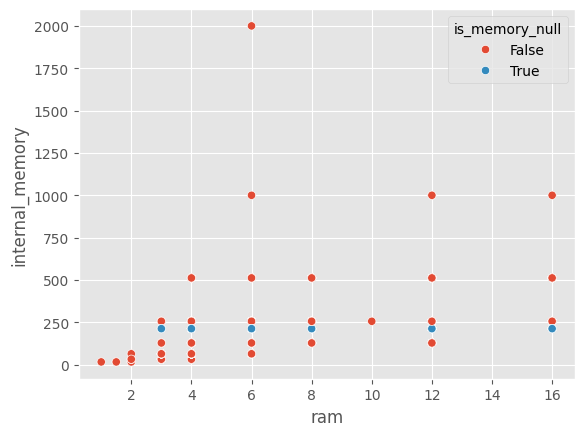

In [9]:
df_copy["is_memory_null"] = np.where(df_copy["internal_memory"].isnull(), True, False)
df_copy["internal_memory"] = df_copy["internal_memory"].fillna(df_copy["internal_memory"].mean())
sns.scatterplot(data=df_copy, x="ram", y="internal_memory", hue="is_memory_null")

Filling them with the mean `internal_memory` value seems alright. This is what we implemented earlier in using the `fill_na=True` argument in the `clean_df` function. 

We can save the cleaned dataset for later. When we want to reload the clean dataset, we can just read the file just like csv so that we don't need to run the entire cleaning process.

In [10]:
df.to_parquet("mobile_dataset_2025_cleaned.parquet", index=False)

# Data Analysis

Now comes the fun part!

When I start an EDA, I always begin by defining a clear set of questions I want to answer. Without a focused scope, analysis can easily spiral into endless plots and insights that, while interesting, may not directly address the problem at hand. There’s nothing wrong with going deeper, but staying aligned with your main goal keeps the analysis meaningful and efficient.

In this case, my ultimate objective is to identify the best value smartphones available right now. To get there, I’ve narrowed down my analysis to the following key questions:

- How do hardware specifications such as RAM, camera quality, battery capacity, internal storage, and screen size affect a phone’s price?
- How have smartphone prices changed over time?
- How have phones evolved across years? For example, are they becoming lighter or more powerful?
- What are the best options in the budget, mid-range, and flagship categories?
  
You’ll notice I included a question about price trends and that’s because understanding pricing over time adds context. However, I won’t dive too deeply into pricing models or forecasting. Instead, I’ll keep the focus on comparing features and value to help answer the final, most important question:

👉 **Which phones offer the best value for their price today?**

By sticking to these targeted questions, we can ensure the analysis stays relevant, actionable, and ultimately useful for real-world decision-making.

In [11]:
df = pd.read_parquet("mobile_dataset_2025_cleaned.parquet")
df.head()

,company_name,mobile_weight,ram,front_camera,back_camera,battery_capacity,screen_size,launched_price_pakistan,launched_price_india,launched_price_china,launched_price_usa,launched_price_dubai,launched_year,model,internal_memory,series,processor_name,processor_type
0,apple,174.0,6.0,12,48,3600,6.1,224999.0,79999.0,5799.0,799.0,2799.0,2024,iphone,128.0,16,a17,bionic
1,apple,174.0,6.0,12,48,3600,6.1,234999.0,84999.0,6099.0,849.0,2999.0,2024,iphone,256.0,16,a17,bionic
2,apple,174.0,6.0,12,48,3600,6.1,244999.0,89999.0,6499.0,899.0,3199.0,2024,iphone,512.0,16,a17,bionic
3,apple,203.0,6.0,12,48,4200,6.7,249999.0,89999.0,6199.0,899.0,3199.0,2024,iphone,128.0,16 plus,a17,bionic
4,apple,203.0,6.0,12,48,4200,6.7,259999.0,94999.0,6499.0,949.0,3399.0,2024,iphone,256.0,16 plus,a17,bionic


When the dtypes are correctly casted to either `int` or `float`, `pandas` will automatically provide the numerical statistic when we call `.describe()`

In [12]:
df.describe()

,mobile_weight,ram,front_camera,back_camera,battery_capacity,screen_size,launched_price_pakistan,launched_price_india,launched_price_china,launched_price_usa,launched_price_dubai,launched_year,internal_memory
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,228.267097,7.793548,18.105376,55.375269,5026.163441,7.083796,125392.583871,50576.818280,3805.087097,619.856989,2183.933333,2022.193548,212.524422
std,105.432503,3.185655,12.034024,36.925638,1355.548264,1.533690,101547.486016,40960.179361,2726.842552,1349.236519,1565.631642,1.862080,140.726617
min,135.000000,1.000000,1.000000,2.000000,2000.000000,5.000000,15999.000000,5999.000000,499.000000,0.000000,299.000000,2014.000000,16.000000
25%,185.000000,6.000000,8.000000,25.000000,4402.500000,6.500000,54999.000000,19999.000000,1699.250000,249.000000,1000.000000,2021.000000,128.000000
50%,194.000000,8.000000,16.000000,50.000000,5000.000000,6.670000,85000.000000,34999.000000,2800.000000,449.000000,1675.000000,2023.000000,212.524422
75%,208.000000,8.000000,32.000000,64.000000,5091.250000,6.780000,179999.000000,74900.000000,5499.000000,849.000000,3199.000000,2024.000000,256.000000
max,732.000000,16.000000,60.000000,212.000000,11200.000000,14.600000,604999.000000,274999.000000,17999.000000,39622.000000,11099.000000,2025.000000,2000.000000


In [13]:
df.describe(include=["O"])

,company_name,model,series,processor_name,processor_type
count,930,930,930,930,930
unique,18,190,347,15,186
top,oppo,galaxy,,qualcomm,bionic
freq,129,88,134,372,91


## Basic Distribution Check

Before actually doing the analysis based on the questions, I like to check the feature distributions. This is useful later when we get to the statistical test.

### Categorical Distribution

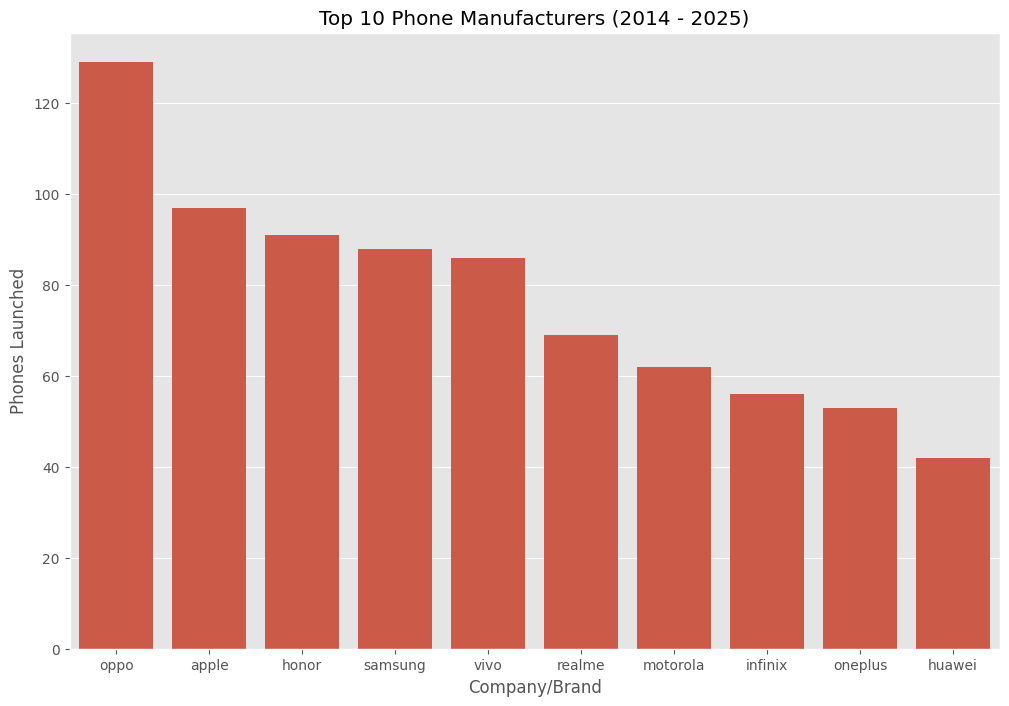

In [14]:
top_manufacturers = (df
    .filter(["company_name"])
    .value_counts()
    .reset_index()
    .head(10)
)
plt.figure(figsize=(12,8))
ax = sns.barplot(data=top_manufacturers, x="company_name", y="count")
ax.set_title("Top 10 Phone Manufacturers (2014 - 2025)")
ax.set_ylabel("Phones Launched")
ax.set_xlabel("Company/Brand")
plt.show()

Just from the first bar chart visualization, we can already see some Chinese companies are catching up with the big phone companies like *Apple* and *Samsung*.

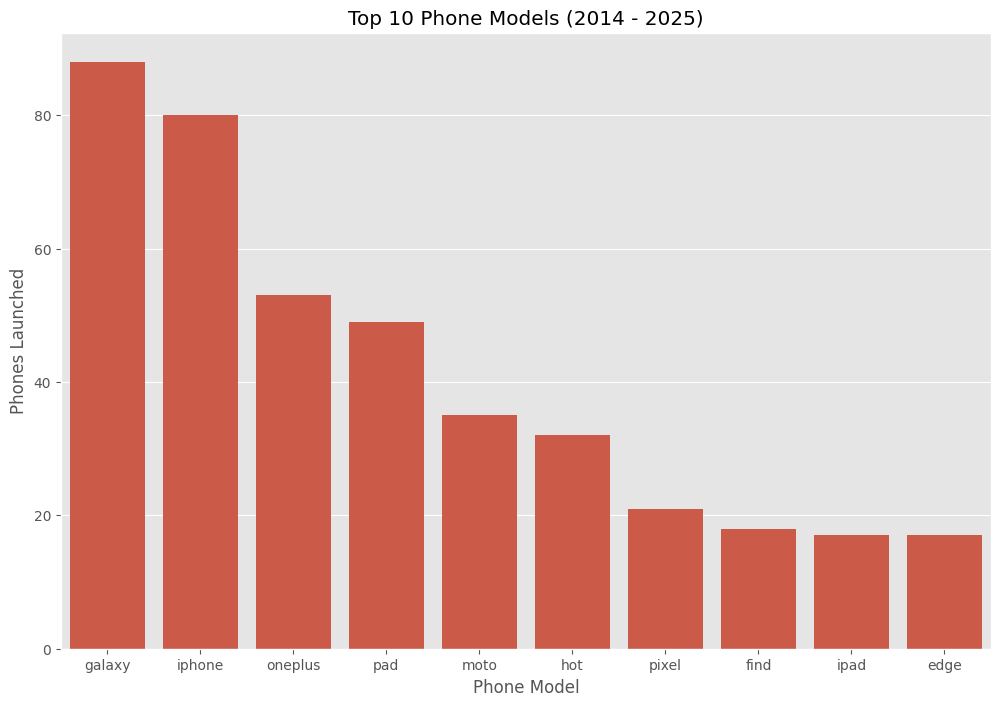

In [15]:
top_phone_models = (df
    .filter(["model"])
    .value_counts()
    .reset_index()
    .head(10)
)

plt.figure(figsize=(12,8))
ax = sns.barplot(data=top_phone_models, x="model", y="count")
ax.set_title("Top 10 Phone Models (2014 - 2025)")
ax.set_ylabel("Phones Launched")
ax.set_xlabel("Phone Model")
plt.show()

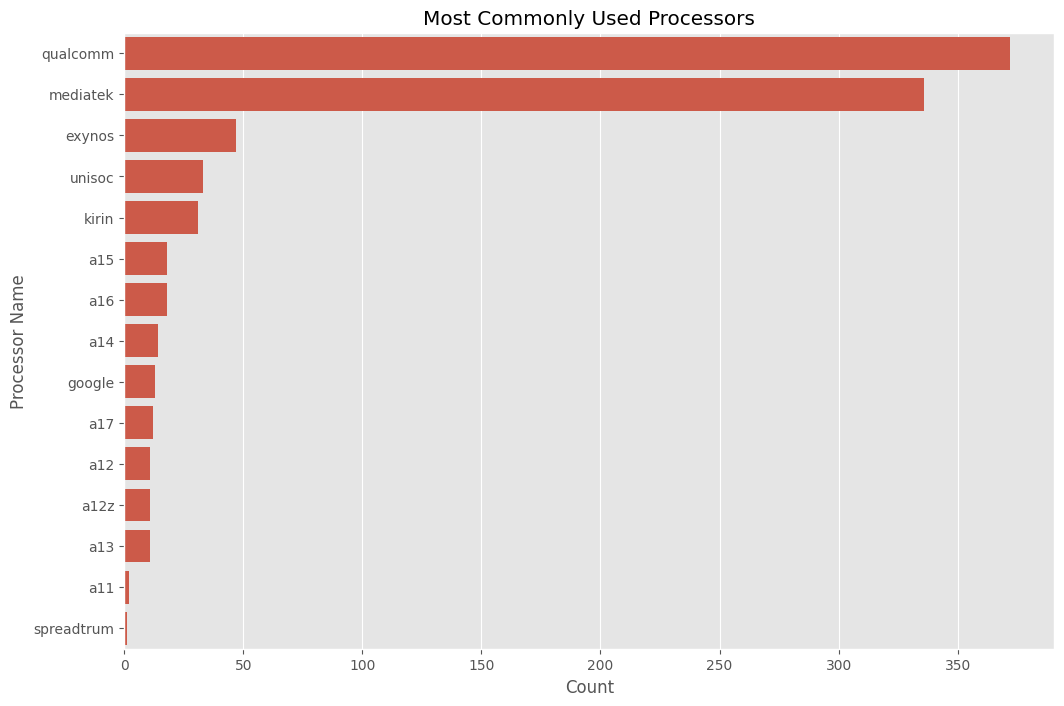

In [16]:
processor_df = (df
                .filter(["processor_name"])
                .value_counts()
                .to_frame()
                .reset_index()
)

plt.figure(figsize=(12,8))
sns.barplot(data=processor_df, y="processor_name", x="count")
plt.title("Most Commonly Used Processors")
plt.ylabel("Processor Name")
plt.xlabel("Count")
plt.show()

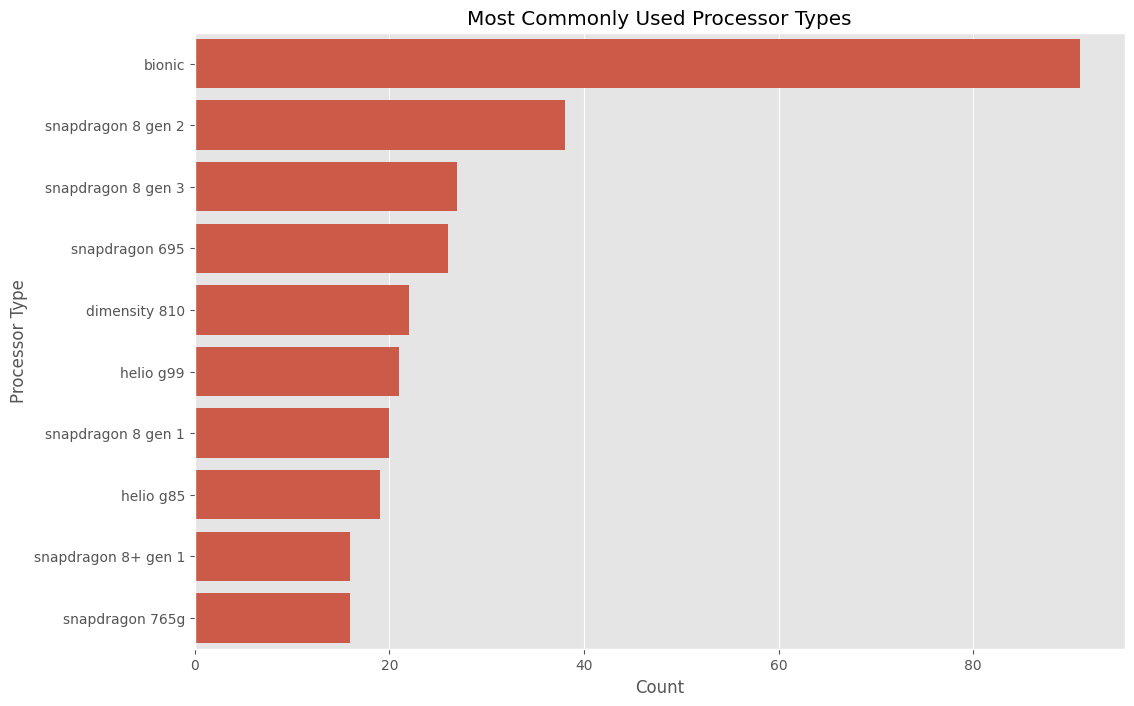

In [17]:
top_processor_types_df = (df
    .filter(["processor_type"])
    .value_counts()
    .reset_index()
    .head(10)
)

plt.figure(figsize=(12,8))
sns.barplot(data=top_processor_types_df, y="processor_type", x="count")
plt.title("Most Commonly Used Processor Types")
plt.ylabel("Processor Type")
plt.xlabel("Count")
plt.show()

### Numerical Distribution

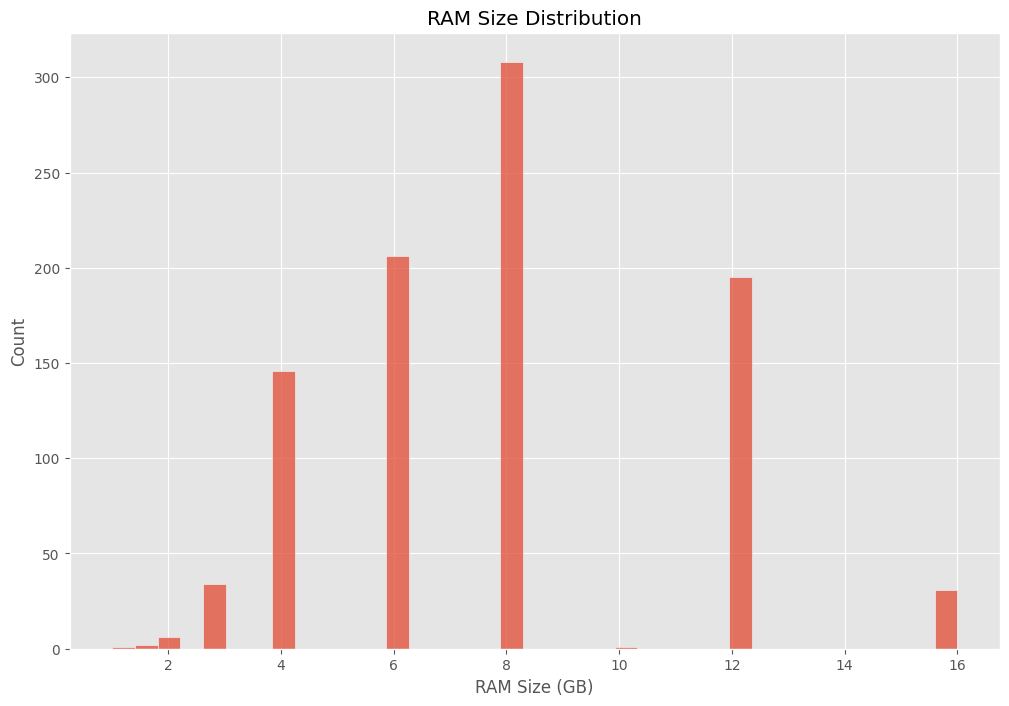

In [18]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x="ram")

plt.title("RAM Size Distribution")
plt.xlabel("RAM Size (GB)")
plt.ylabel("Count")
plt.show()

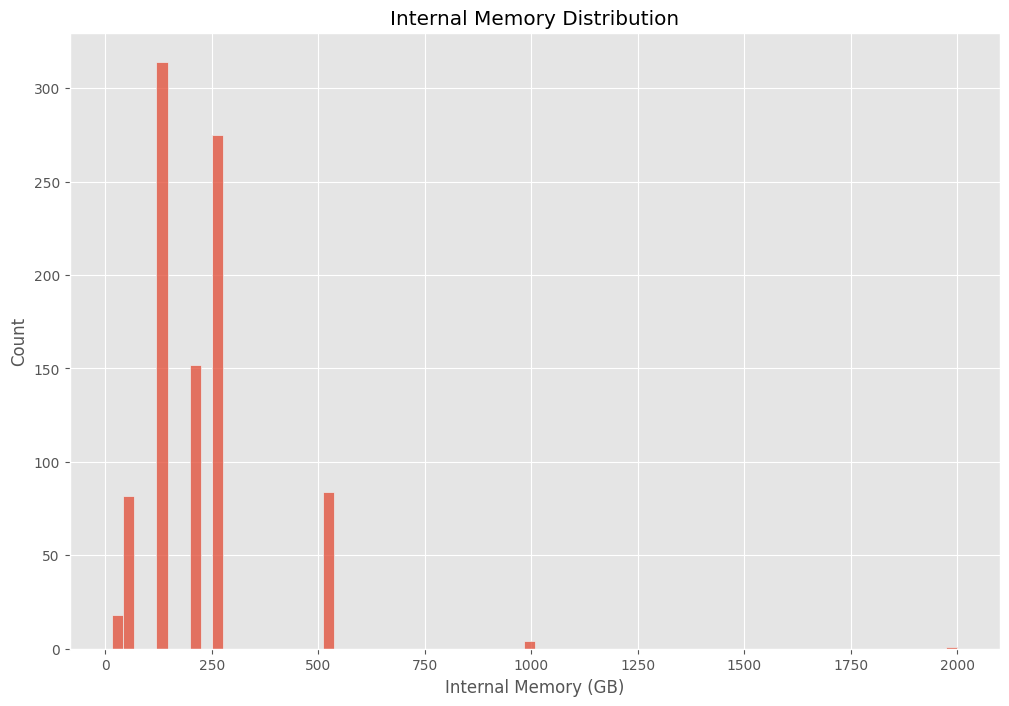

In [19]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x="internal_memory")

plt.title("Internal Memory Distribution")
plt.xlabel("Internal Memory (GB)")
plt.ylabel("Count")
plt.show()

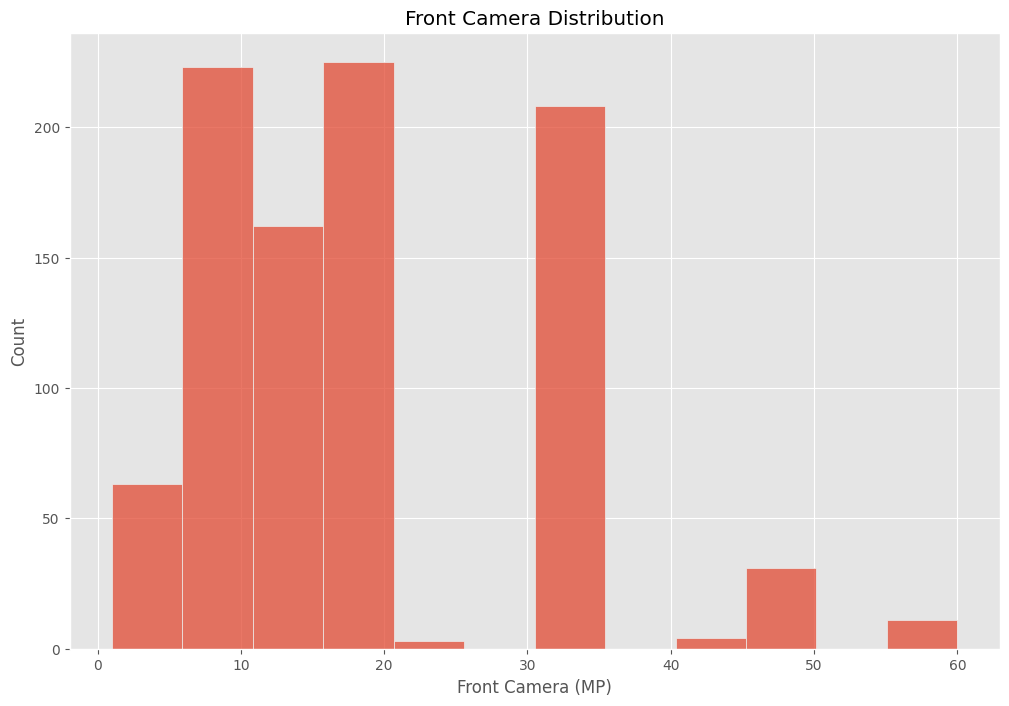

In [20]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x="front_camera")

plt.title("Front Camera Distribution")
plt.xlabel("Front Camera (MP)")
plt.ylabel("Count")
plt.show()

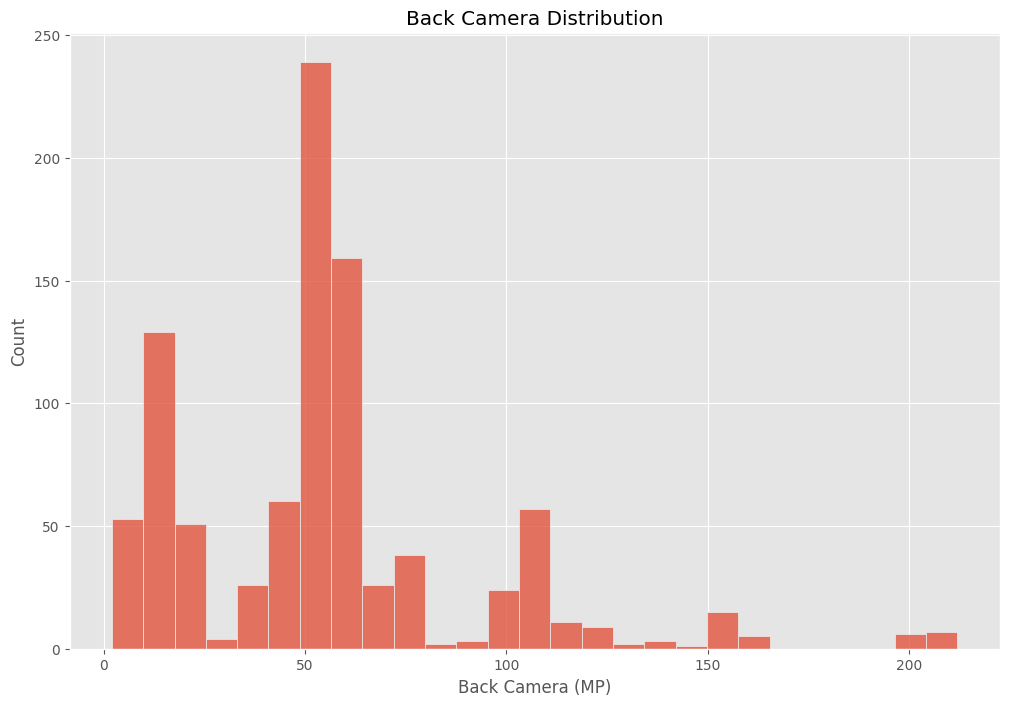

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x="back_camera")

plt.title("Back Camera Distribution")
plt.xlabel("Back Camera (MP)")
plt.ylabel("Count")
plt.show()

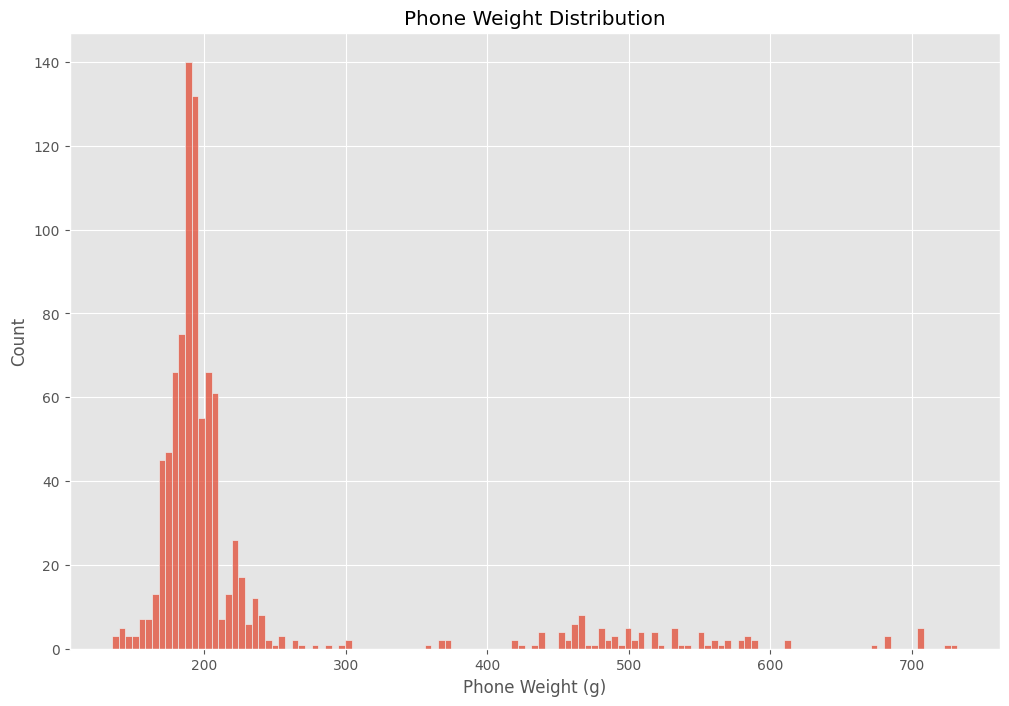

In [22]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x="mobile_weight")

plt.title("Phone Weight Distribution")
plt.xlabel("Phone Weight (g)")
plt.ylabel("Count")
plt.show()

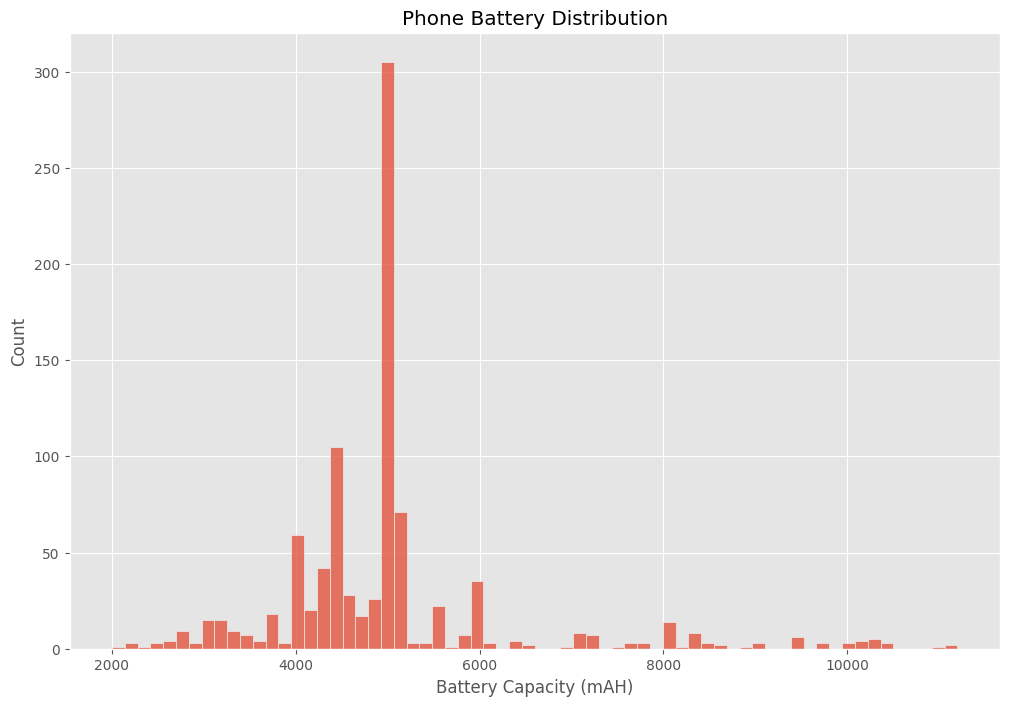

In [23]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x="battery_capacity")

plt.title("Phone Battery Distribution")
plt.xlabel("Battery Capacity (mAH)")
plt.ylabel("Count")
plt.show()

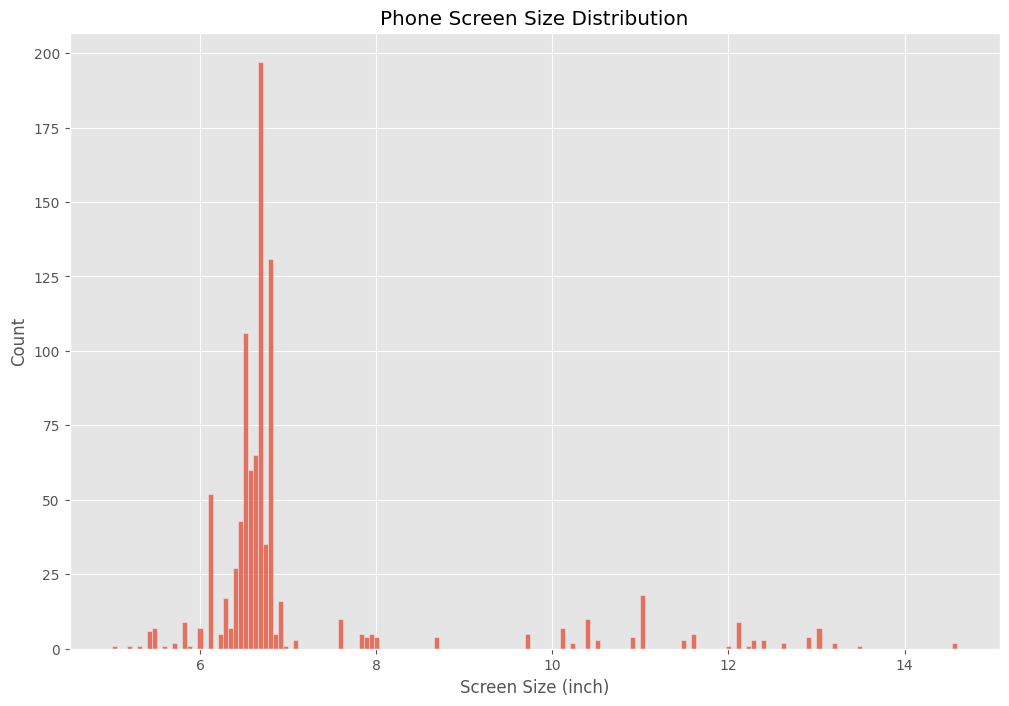

In [24]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x="screen_size")

plt.title("Phone Screen Size Distribution")
plt.xlabel("Screen Size (inch)")
plt.ylabel("Count")
plt.show()

In [25]:
df.columns

Index(['company_name', 'mobile_weight', 'ram', 'front_camera', 'back_camera',
       'battery_capacity', 'screen_size', 'launched_price_pakistan',
       'launched_price_india', 'launched_price_china', 'launched_price_usa',
       'launched_price_dubai', 'launched_year', 'model', 'internal_memory',
       'series', 'processor_name', 'processor_type'],
      dtype='object')

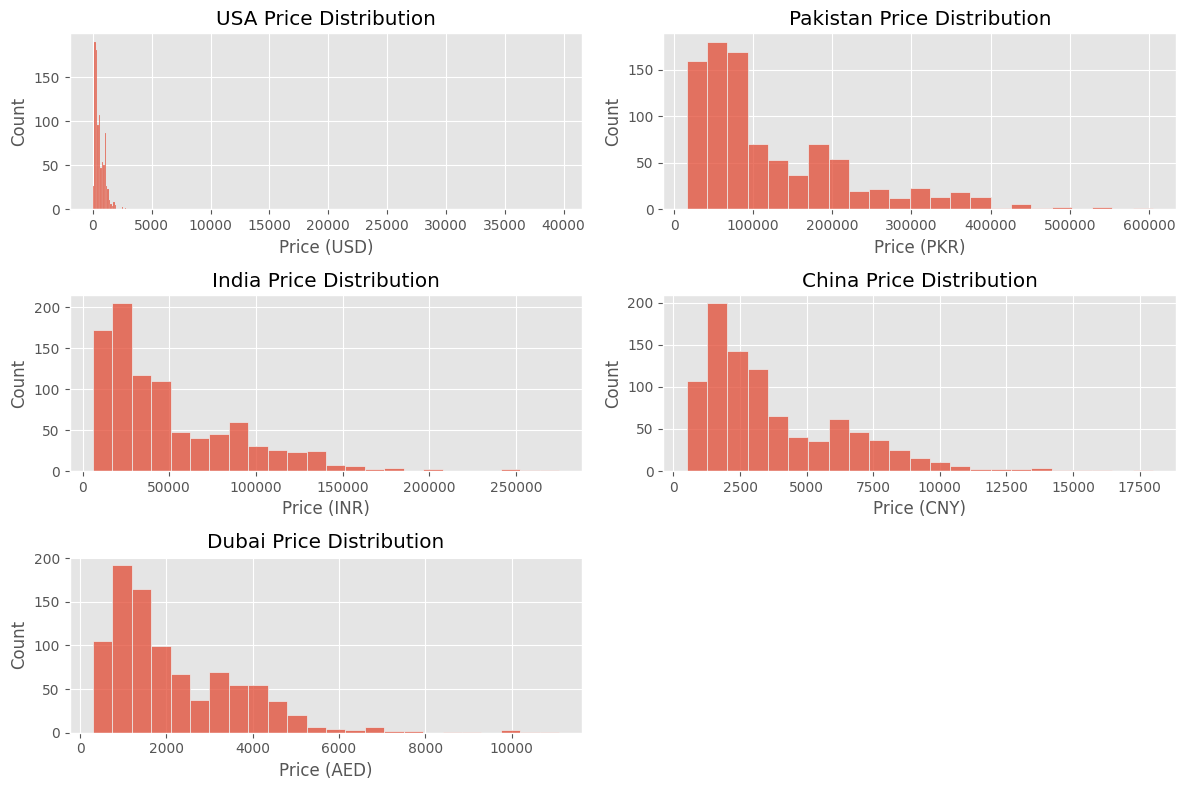

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

sns.histplot(data=df, x="launched_price_usa", ax=axes[0][0])
axes[0][0].set_title("USA Price Distribution")
axes[0][0].set_xlabel("Price (USD)")
axes[0][0].set_ylabel("Count")

sns.histplot(data=df, x="launched_price_pakistan", ax=axes[0][1])
axes[0][1].set_title("Pakistan Price Distribution")
axes[0][1].set_xlabel("Price (PKR)")
axes[0][1].set_ylabel("Count")

sns.histplot(data=df, x="launched_price_india", ax=axes[1][0])
axes[1][0].set_title("India Price Distribution")
axes[1][0].set_xlabel("Price (INR)")
axes[1][0].set_ylabel("Count")

sns.histplot(data=df, x="launched_price_china", ax=axes[1][1])
axes[1][1].set_title("China Price Distribution")
axes[1][1].set_xlabel("Price (CNY)")
axes[1][1].set_ylabel("Count")

sns.histplot(data=df, x="launched_price_dubai", ax=axes[2][0])
axes[2][0].set_title("Dubai Price Distribution")
axes[2][0].set_xlabel("Price (AED)")
axes[2][0].set_ylabel("Count")

fig.delaxes(axes[2][1])

plt.tight_layout()
plt.show()

From all numerical distribution, it seems like most of them have skewed distributions. On top of that, we can see obvious outliers on `launched_price_usa`

Text(0, 0.5, 'Number of Phones Launched')

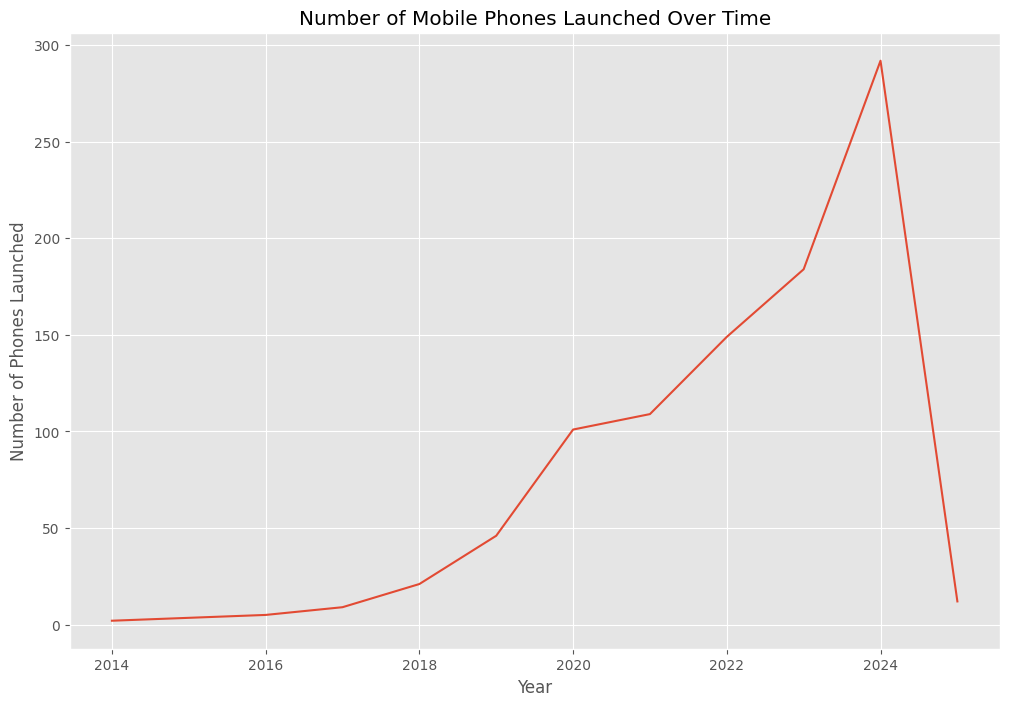

In [27]:
phones_launched_per_year_df = (df
                               .filter(["launched_year"])
                               .value_counts()
                               .reset_index()
                               .sort_values(by=["launched_year"])
)

plt.figure(figsize=(12,8))
sns.lineplot(data=phones_launched_per_year_df, x="launched_year", y="count")

plt.title("Number of Mobile Phones Launched Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Phones Launched")

I'm not sure whether the data is focused more on the recently launched phones or not because the number of phones launched before 2020 were too little. Regardless, let's proceed with the analysis.

Remember the outliers we saw earlier in `launched_price_usa`?

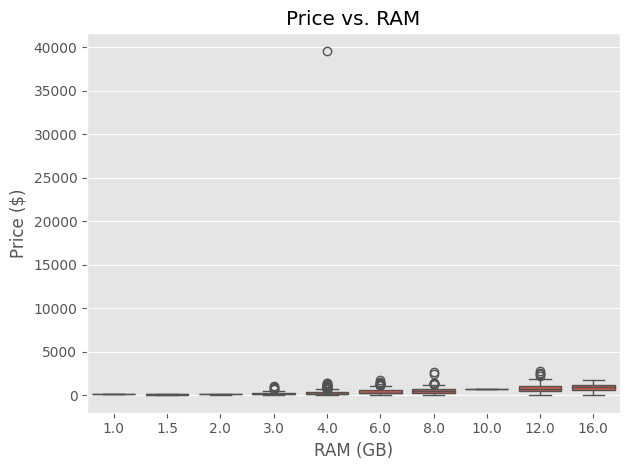

In [28]:
ram_vs_price_df = df[["ram", "launched_price_usa"]].copy()
sns.boxplot(data=ram_vs_price_df, x="ram", y="launched_price_usa")

plt.title("Price vs. RAM")
plt.xlabel("RAM (GB)")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

It's weird that a 4GB Nokia T21 was priced almost $40,000 a unit. This must be either a data entry error or a typo. According to [GSM Arena](https://www.gsmarena.com/nokia_t21-11823.php), the launch price for Nokia T21 was 240 EUR (~281 USD) 

In [29]:
df[df["launched_price_usa"] > 35000]

,company_name,mobile_weight,ram,front_camera,back_camera,battery_capacity,screen_size,launched_price_pakistan,launched_price_india,launched_price_china,launched_price_usa,launched_price_dubai,launched_year,model,internal_memory,series,processor_name,processor_type
685,nokia,466.0,4.0,8,8,8200,10.4,52000.0,17999.0,1250.0,39622.0,870.0,2022,t21,212.524422,,unisoc,t612


You might be thinking: *Can’t we just manually correct the price for this one entry?*

And yes, you’re absolutely right. Since this is just a single outlier in a dataset of 390 entries, directly updating the value would be reasonable and have minimal impact.

However, I’d like to introduce a more scalable and systematic approach to handling outliers that’s widely used in data analysis and machine learning pipelines. While a quick fix works fine now, building robust data-cleaning workflows prepares us for bigger, messier datasets down the line. 

How about prices <= 0?

In [30]:
df[df["launched_price_usa"] <= 0]

,company_name,mobile_weight,ram,front_camera,back_camera,battery_capacity,screen_size,launched_price_pakistan,launched_price_india,launched_price_china,launched_price_usa,launched_price_dubai,launched_year,model,internal_memory,series,processor_name,processor_type
537,xiaomi,205.0,12.0,16,210,5110,6.67,99999.0,32999.0,2799.0,0.0,1599.0,2024,redmi,256.0,note 14 pro+ 5g,qualcomm,snapdragon 7s gen 3
538,xiaomi,205.0,16.0,16,210,5110,6.67,109999.0,35999.0,3099.0,0.0,1699.0,2024,redmi,512.0,note 14 pro+ 5g,qualcomm,snapdragon 7s gen 3
539,xiaomi,195.0,8.0,16,118,5500,6.67,79999.0,27999.0,2199.0,0.0,1399.0,2024,redmi,128.0,note 14 pro 5g,mediatek,dimensity 7300-ultra
540,xiaomi,195.0,12.0,16,118,5500,6.67,89999.0,30999.0,2499.0,0.0,1499.0,2024,redmi,256.0,note 14 pro 5g,mediatek,dimensity 7300-ultra
541,xiaomi,190.0,6.0,16,118,5000,6.67,69999.0,24999.0,1999.0,0.0,1199.0,2024,redmi,128.0,note 14 pro 4g,qualcomm,snapdragon 732g
542,xiaomi,190.0,8.0,16,118,5000,6.67,79999.0,27999.0,2299.0,0.0,1299.0,2024,redmi,256.0,note 14 pro 4g,qualcomm,snapdragon 732g
543,xiaomi,185.0,6.0,16,60,5000,6.67,59999.0,21999.0,1799.0,0.0,1099.0,2024,redmi,128.0,note 14 5g,mediatek,dimensity 7025-ultra
544,xiaomi,185.0,8.0,16,60,5000,6.67,69999.0,24999.0,2099.0,0.0,1199.0,2024,redmi,256.0,note 14 5g,mediatek,dimensity 7025-ultra
545,xiaomi,180.0,4.0,16,60,5000,6.67,49999.0,18999.0,1599.0,0.0,999.0,2024,redmi,128.0,note 14 4g,qualcomm,snapdragon 680
546,xiaomi,180.0,6.0,16,60,5000,6.67,59999.0,21999.0,1899.0,0.0,1099.0,2024,redmi,256.0,note 14 4g,qualcomm,snapdragon 680


We’ve identified some phones with a price of $0. Upon examining the models, it appears these are primarily *Xiaomi* devices, which are typically not officially launched in the U.S. market. This explains the missing (zero) pricing data—these phones aren't sold through U.S. retail channels.

To ensure our analysis reflects realistic market prices, we’ll focus only on smartphones officially launched in the U.S. From this point forward, we’ll filter the dataset accordingly.

Now, regarding the price outliers we just observed, instead of removing them entirely, we can use a technique called quantile clipping to cap extreme values. This involves setting lower and upper bounds based on the 1st and 99th percentiles of the price distribution. Any price below the 1st percentile will be set to that lower bound, and any price above the 99th percentile will be capped at the upper bound.

This approach helps reduce the influence of extreme outliers while preserving the overall structure of the data, making our analysis more robust without losing valuable information.

In [31]:
usa_phones_df = df.query("launched_price_usa > 0")

low = usa_phones_df['launched_price_usa'].quantile(0.01)
high = usa_phones_df['launched_price_usa'].quantile(0.99)
low, high

(np.float64(99.0), np.float64(1899.0))

In [32]:
usa_phones_df['launched_price_usa'] = usa_phones_df['launched_price_usa'].clip(low, high)

C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\3576476262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_phones_df['launched_price_usa'] = usa_phones_df['launched_price_usa'].clip(low, high)


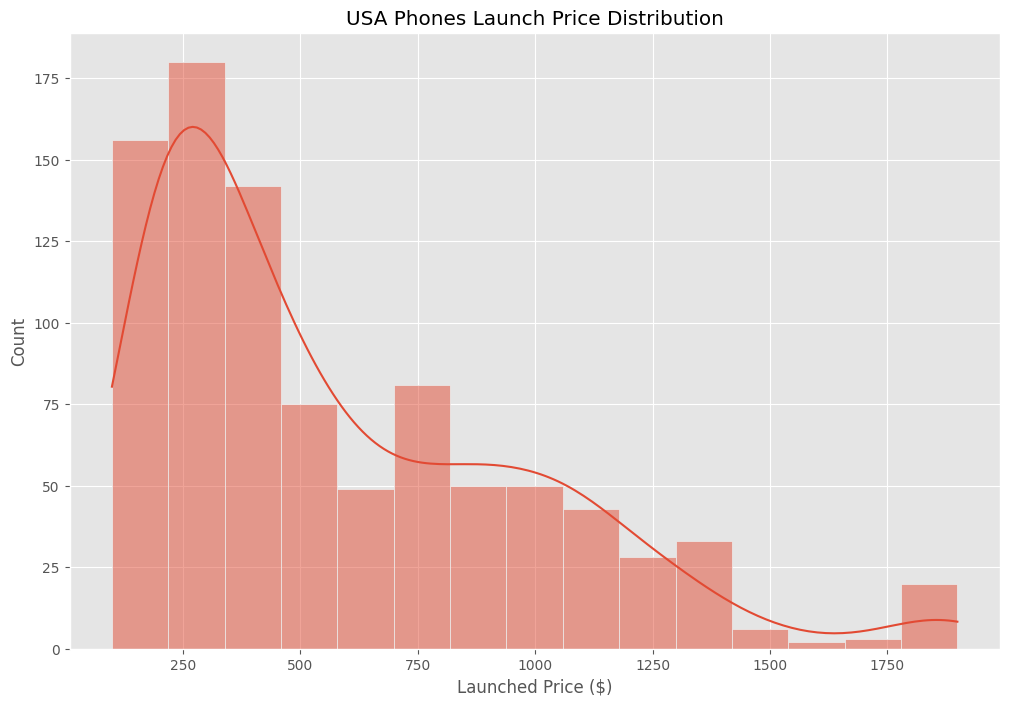

In [33]:
plt.figure(figsize=(12,8))
sns.histplot(data=usa_phones_df, x="launched_price_usa", kde=True)

plt.title("USA Phones Launch Price Distribution")
plt.xlabel("Launched Price ($)")
plt.show()

## Phone Specs & Price

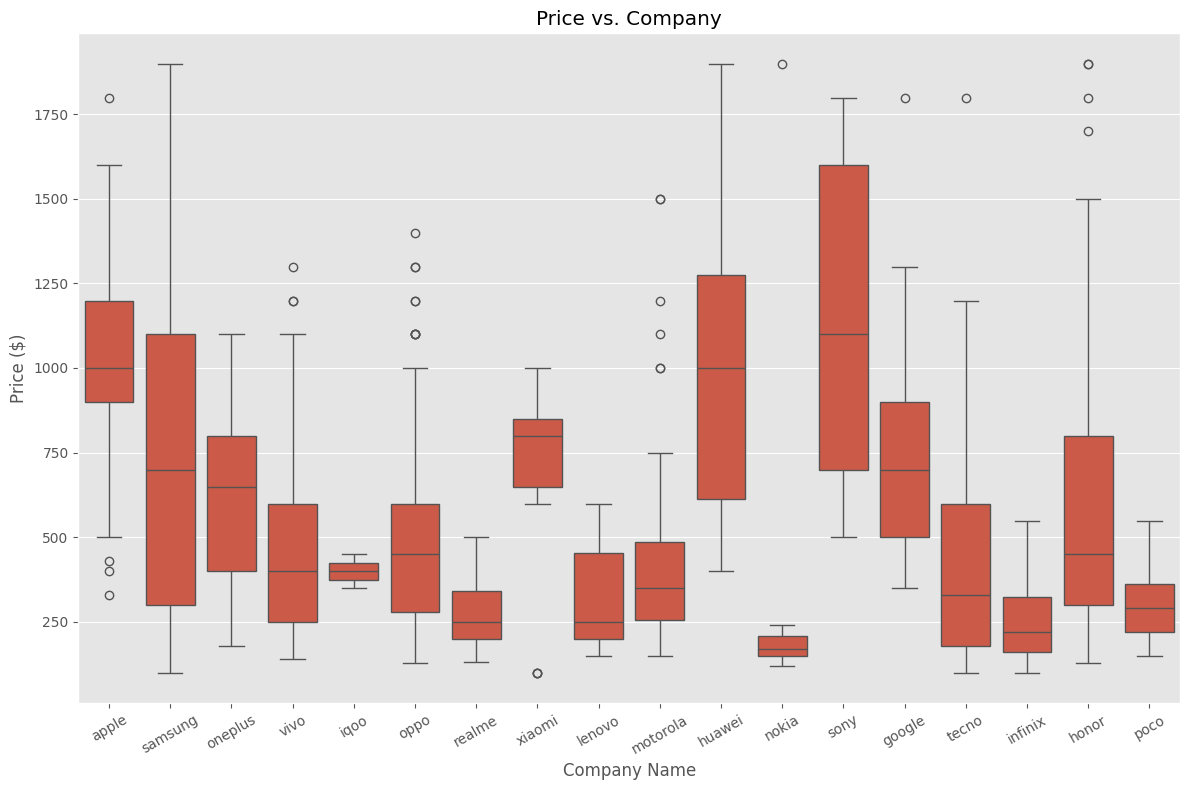

In [34]:
company_vs_price_df = usa_phones_df[["company_name", "launched_price_usa"]].copy()

plt.figure(figsize=(12,8))
sns.boxplot(data=company_vs_price_df, x="company_name", y="launched_price_usa")

plt.title("Price vs. Company")
plt.xlabel("Company Name")
plt.ylabel("Price ($)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

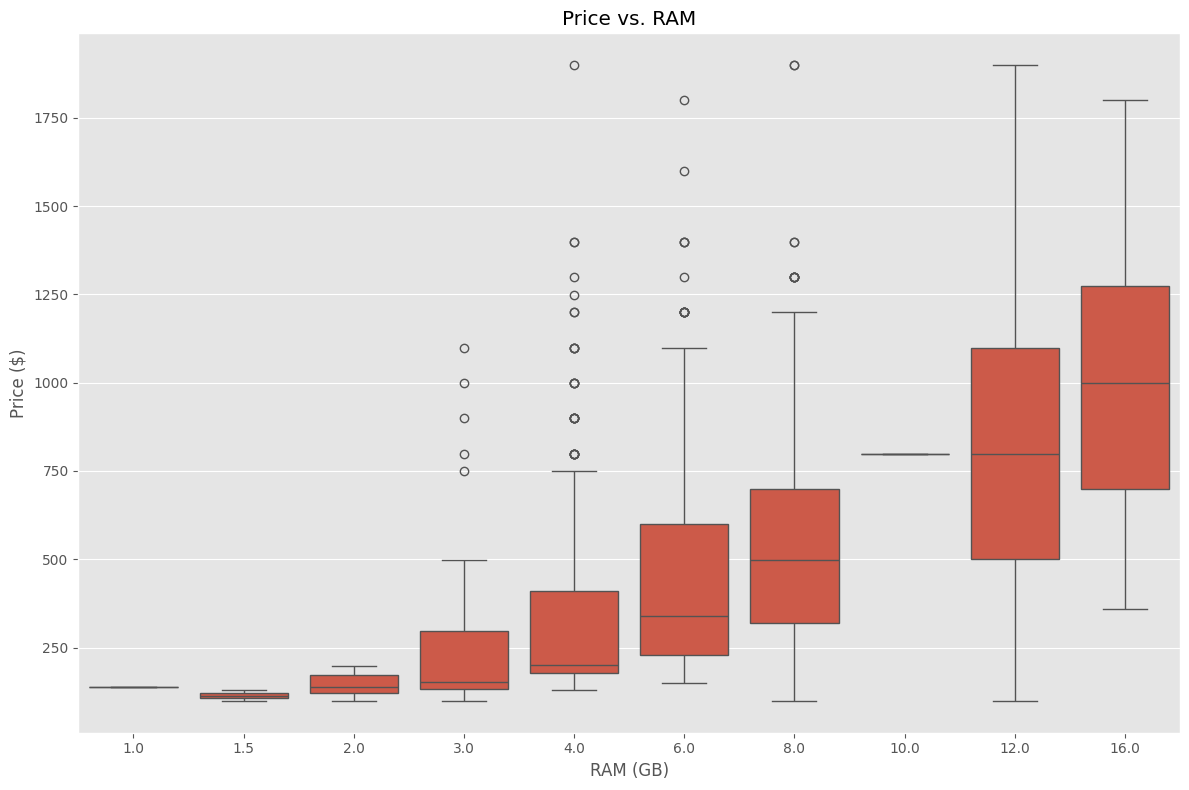

In [35]:
ram_vs_price_df = usa_phones_df[["ram", "launched_price_usa"]].copy()

plt.figure(figsize=(12,8))
sns.boxplot(data=ram_vs_price_df, x="ram", y="launched_price_usa")

plt.title("Price vs. RAM")
plt.xlabel("RAM (GB)")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

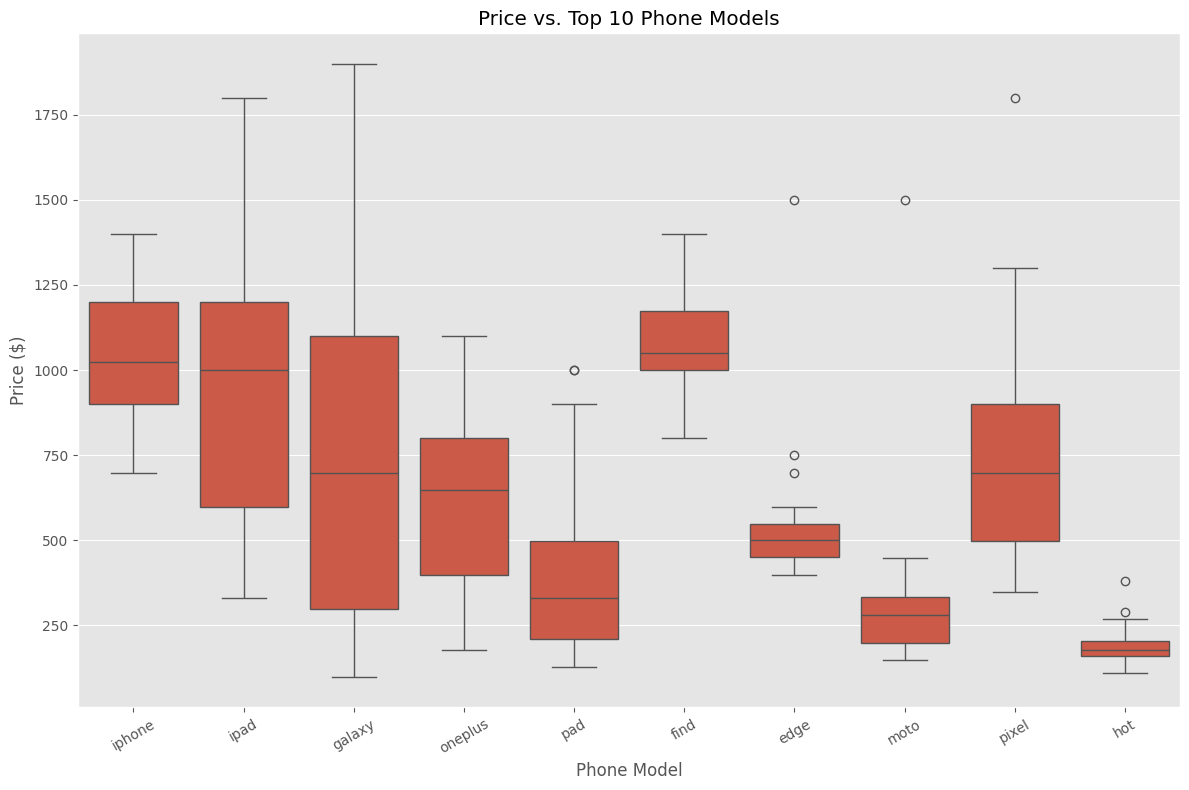

In [36]:
top_phone_models = (usa_phones_df
    .filter(["model"])
    .value_counts()
    .reset_index()
    .head(10)["model"]
    .tolist()
)
model_vs_price_df = (usa_phones_df
                     .filter(["model", "launched_price_usa"])
                     .query("model in @top_phone_models")
)

plt.figure(figsize=(12,8))
sns.boxplot(data=model_vs_price_df, x="model", y="launched_price_usa")

plt.title("Price vs. Top 10 Phone Models")
plt.xlabel("Phone Model")
plt.ylabel("Price ($)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

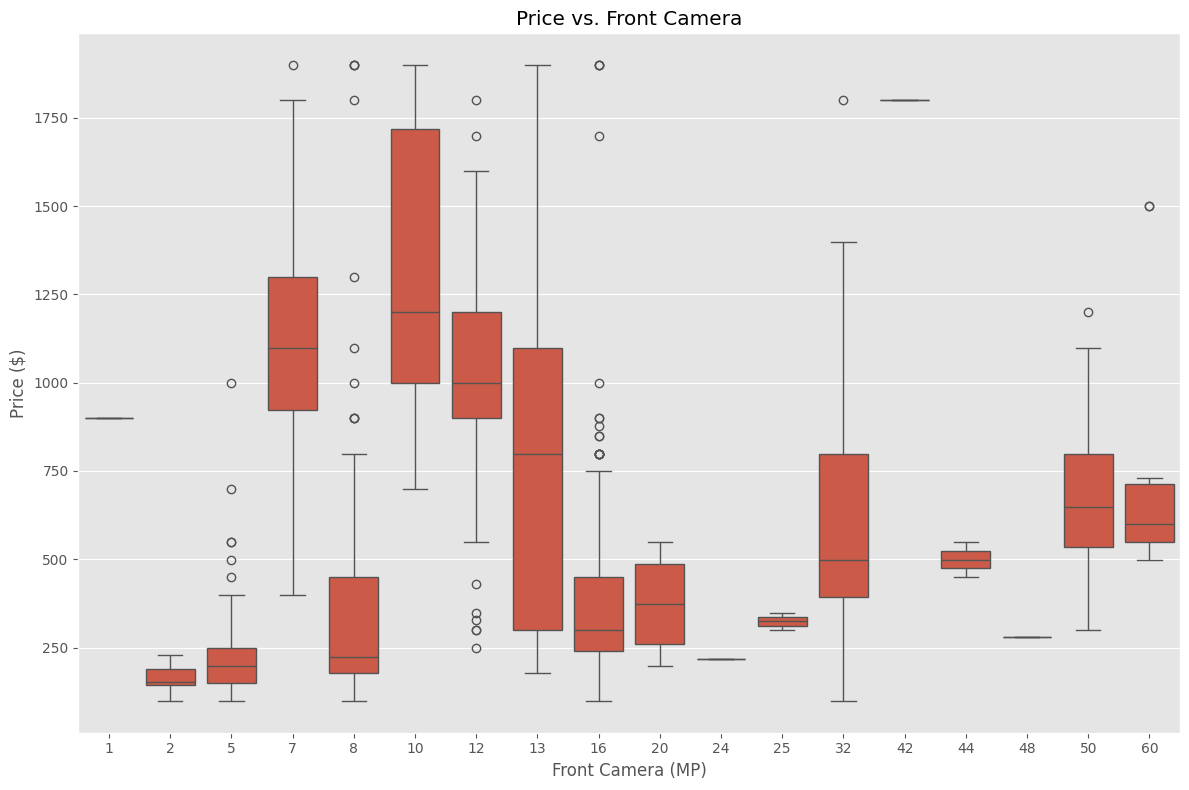

In [37]:
camera_vs_price_df = usa_phones_df[["front_camera", "launched_price_usa"]].copy()

plt.figure(figsize=(12,8))
sns.boxplot(data=camera_vs_price_df, x="front_camera", y="launched_price_usa") 

plt.title("Price vs. Front Camera")
plt.xlabel("Front Camera (MP)")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

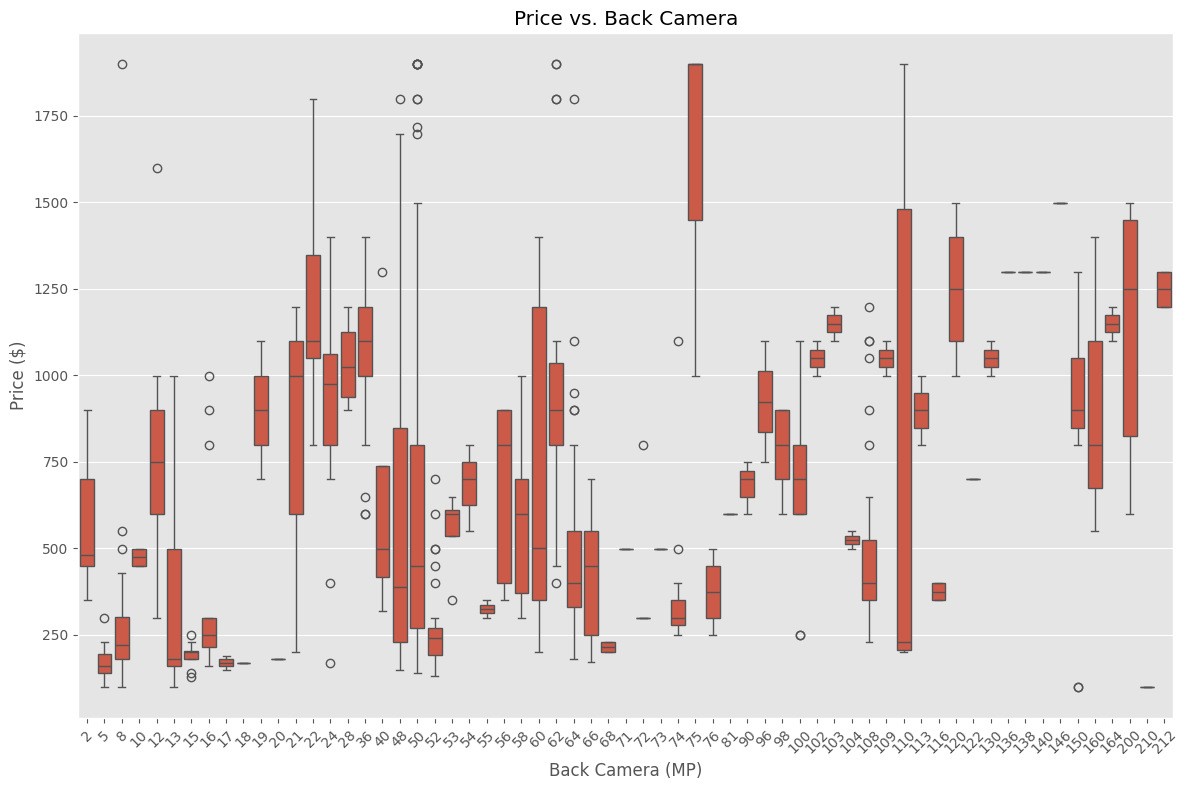

In [38]:
camera_vs_price_df = usa_phones_df[["back_camera", "launched_price_usa"]].copy()

plt.figure(figsize=(12,8))

sns.boxplot(data=camera_vs_price_df, x="back_camera", y="launched_price_usa") 

plt.title("Price vs. Back Camera")
plt.xlabel("Back Camera (MP)")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

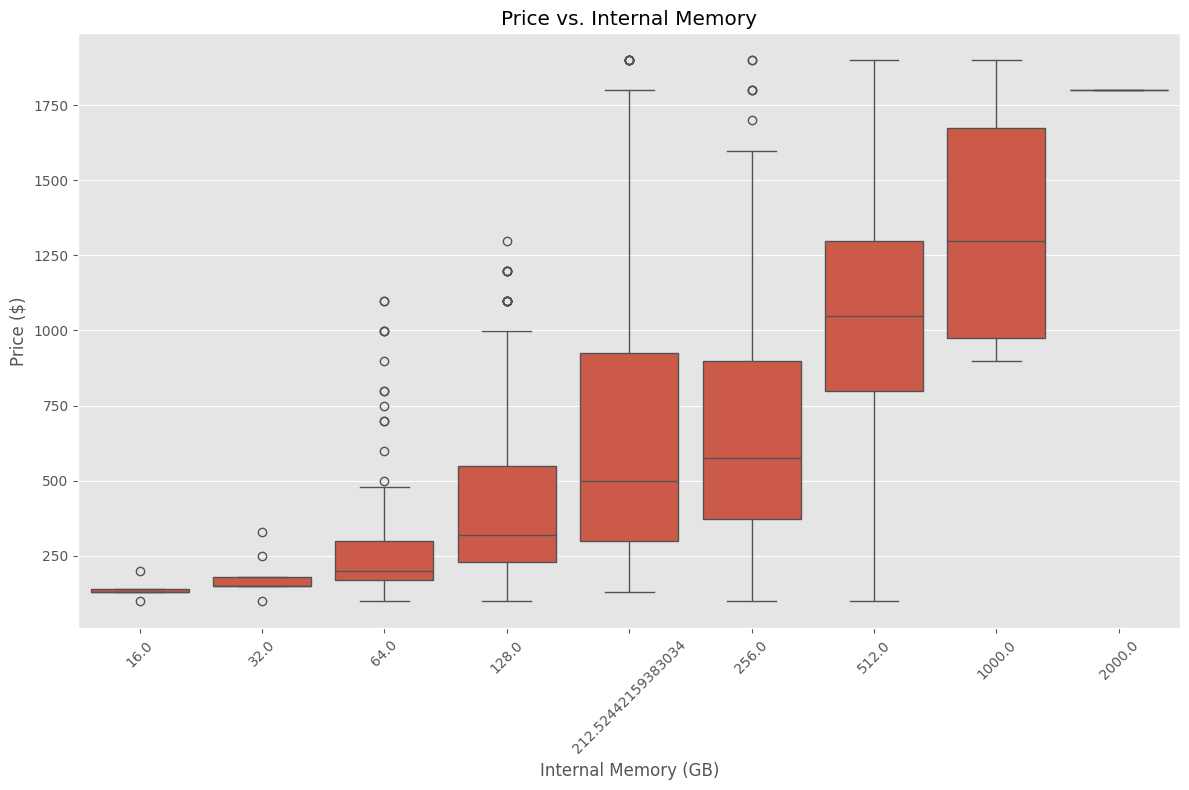

In [39]:
processor_name_vs_price_df = usa_phones_df[["internal_memory", "launched_price_usa"]].copy()

plt.figure(figsize=(12,8))

sns.boxplot(data=processor_name_vs_price_df, x="internal_memory", y="launched_price_usa") 

plt.title("Price vs. Internal Memory")
plt.xlabel("Internal Memory (GB)")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

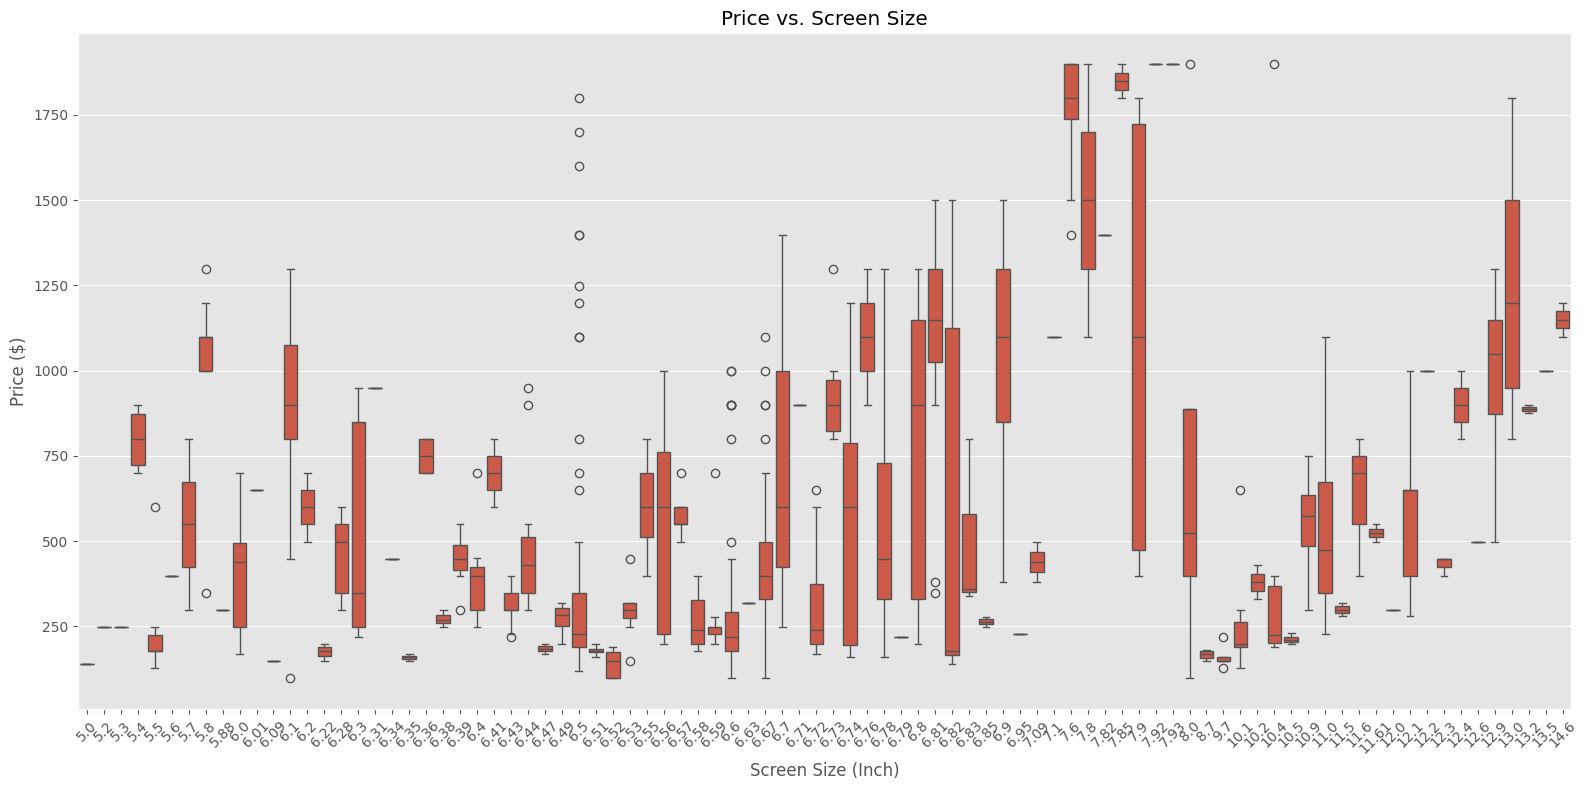

In [40]:
screen_vs_price_df = usa_phones_df[["screen_size", "launched_price_usa"]].copy()

plt.figure(figsize=(16,8))

sns.boxplot(data=screen_vs_price_df, x="screen_size", y="launched_price_usa") 

plt.title("Price vs. Screen Size")
plt.xlabel("Screen Size (Inch)")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

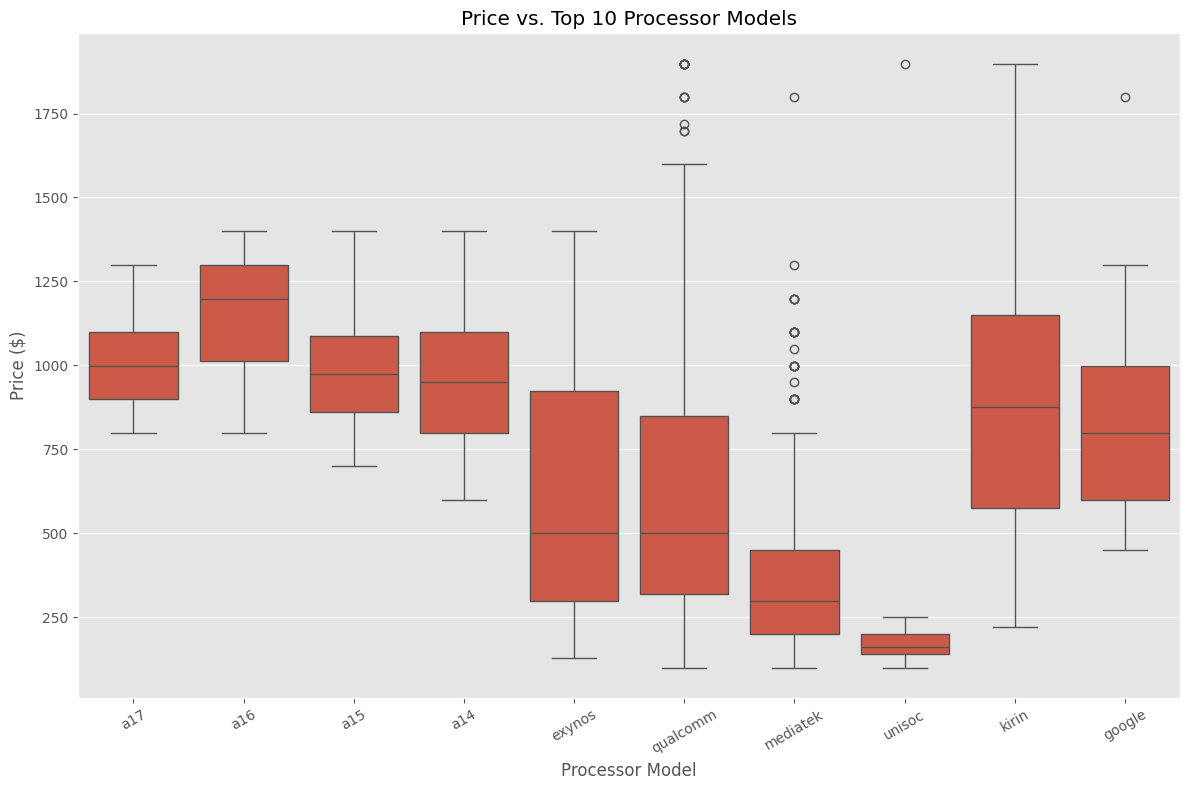

In [41]:
top_processor_models = (usa_phones_df
    .filter(["processor_name"])
    .value_counts()
    .reset_index()
    .head(10)["processor_name"]
    .tolist()
)
processor_name_vs_price_df = (usa_phones_df
                     .filter(["processor_name", "launched_price_usa"])
                     .query("processor_name in @top_processor_models")
)

plt.figure(figsize=(12,8))
sns.boxplot(data=processor_name_vs_price_df, x="processor_name", y="launched_price_usa")

plt.title("Price vs. Top 10 Processor Models")
plt.xlabel("Processor Model")
plt.ylabel("Price ($)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

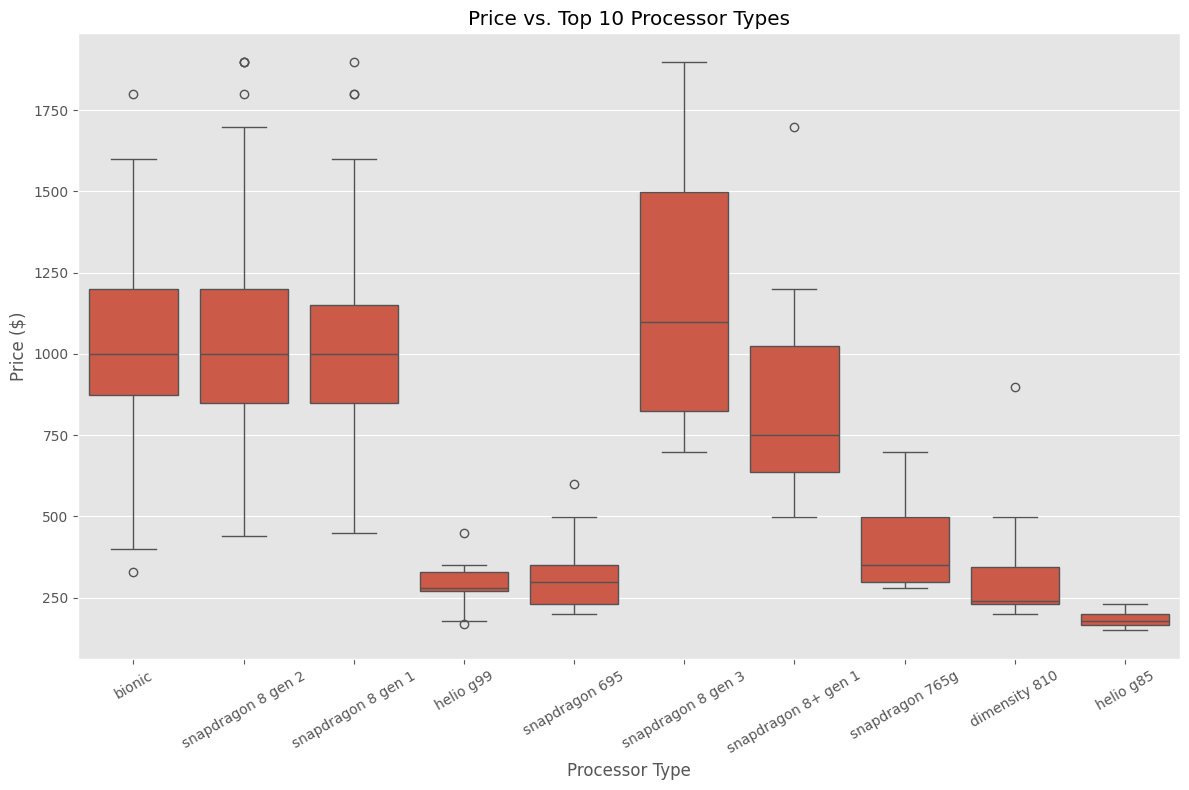

In [42]:
top_processor_types = (usa_phones_df
    .filter(["processor_type"])
    .value_counts()
    .reset_index()
    .head(10)["processor_type"]
    .tolist()
)
processor_type_vs_price_df = (usa_phones_df
                     .filter(["processor_type", "launched_price_usa"])
                     .query("processor_type in @top_processor_types")
)

plt.figure(figsize=(12,8))
sns.boxplot(data=processor_type_vs_price_df, x="processor_type", y="launched_price_usa")

plt.title("Price vs. Top 10 Processor Types")
plt.xlabel("Processor Type")
plt.ylabel("Price ($)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

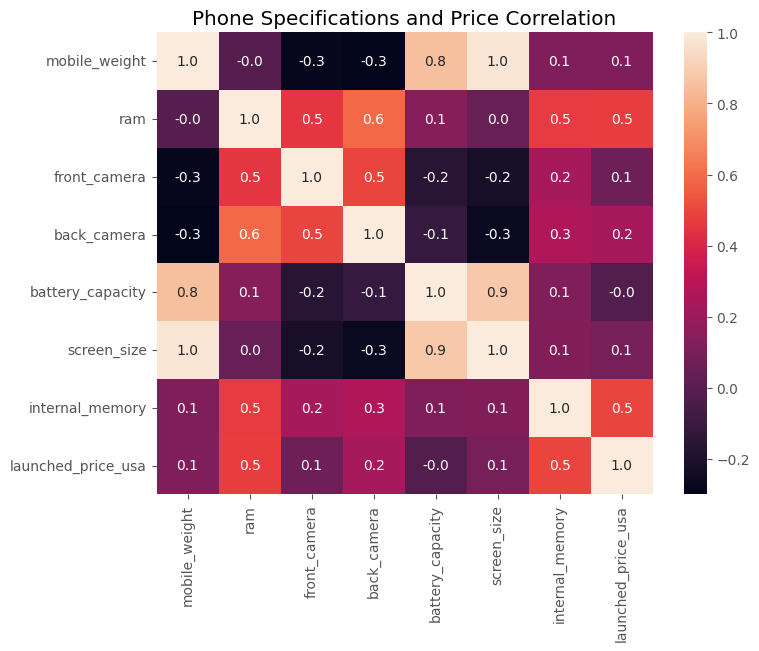

In [43]:
spec_price_corr_df = (usa_phones_df
                .filter(["mobile_weight", "ram", "front_camera", "back_camera", "battery_capacity", 
                         "screen_size", "internal_memory", "launched_price_usa"])
                .corr()
)

plt.figure(figsize=(8,6))
sns.heatmap(spec_price_corr_df, annot=True, fmt=".1f")

plt.title("Phone Specifications and Price Correlation")
plt.show()

The heatmap above effectively summarizes the key relationships in our data. It reveals that **RAM** and **internal memory** are the only features with a moderate positive correlation to price, meaning smartphones with higher RAM and larger storage tend to be more expensive.

Beyond price, we also observe meaningful correlations among other features. For instance, phone weight, battery capacity, and screen size are positively correlated with one another. This makes intuitive sense: larger batteries typically require bigger devices, which often come with larger screens and increased weight. Additionally, there’s a noticeable positive correlation between RAM and both front and rear camera. This could suggest that higher-resolution cameras generate more data and demand greater processing power and memory which is commonly found in high-end devices.

To strengthen these observational insights, we can back them up with statistical tests. As we observed earlier during distribution analysis, most of our numerical variables are skewed and not normally distributed. Therefore, it's appropriate to use non-parametric tests:

- **Spearman’s rank correlation** for numerical variables (to confirm monotonic relationships, like the one between RAM and price).
- **Kruskal-Wallis H test** for categorical variables (e.g., comparing median prices across different processor types).

These tests will help validate whether the patterns we’re seeing are statistically significant, not just visual artifacts.

In [44]:
stat_test_df = df[df["internal_memory"].notnull()]

numerical_features = ["mobile_weight", "ram", "screen_size", "battery_capacity", "internal_memory", "front_camera", "back_camera"]

for col in numerical_features:
    if col != 'launched_price_usd':
        corr, p_value = spearmanr(stat_test_df[col], stat_test_df['launched_price_usa'])
        print(f"{col}: Correlation = {corr:.3f}, p-value = {p_value}")

mobile_weight: Correlation = 0.227, p-value = 2.267555182559036e-12
ram: Correlation = 0.525, p-value = 4.9027420807693975e-67
screen_size: Correlation = 0.189, p-value = 6.810446996949697e-09
battery_capacity: Correlation = -0.209, p-value = 1.1349783715257811e-10
internal_memory: Correlation = 0.527, p-value = 1.0303855368880365e-67
front_camera: Correlation = 0.184, p-value = 1.654460301281505e-08
back_camera: Correlation = 0.202, p-value = 4.978042096343021e-10


In [45]:
categorical_features = ["company_name", "model", "series", "processor_name", "processor_type"]

for col in categorical_features:
    groups = [group['launched_price_usa'].values for name, group in df.groupby(col)]
    h_stat, p_val = kruskal(*groups)
    print(f"{col}: Kruskal-Wallis H-statistic: {h_stat:.3f}, p-value: {p_val}")

company_name: Kruskal-Wallis H-statistic: 349.330, p-value: 6.79716165058171e-64
model: Kruskal-Wallis H-statistic: 693.465, p-value: 9.818397089408352e-59
series: Kruskal-Wallis H-statistic: 679.103, p-value: 6.687820988600421e-24
processor_name: Kruskal-Wallis H-statistic: 316.039, p-value: 5.304023637986885e-59
processor_type: Kruskal-Wallis H-statistic: 809.804, p-value: 5.301796105479495e-79


RAM and internal memory still holds the largest correlation value with relatively small p-values.

## Price Changes

Now that we’ve identified which features like RAM and internal memory influence smartphone prices, we can take a step further and analyze how prices have evolved over time. Understanding price trends across years can help us make better purchasing decisions, such as knowing when to buy or whether prices are likely to drop.

To accurately compare prices across different markets, we need to standardize the currency. Since many phones in the dataset are priced in various foreign currencies, we’ll convert all prices into US Dollars (USD) . This uniformity allows us to create meaningful visualizations and draw reliable insights about global pricing trends over time.

In [46]:
def convert_foreign_prices_to_usd(df):
    exchange_rates = {
        'USD': 1.0,
        'PKR': 0.0035,
        'INR': 0.012,
        'CNY': 0.14,
        'AED': 0.27
    }

    df["usd_to_usd"] = df["launched_price_usa"]
    df["pkr_to_usd"] = df["launched_price_pakistan"] * exchange_rates["PKR"]
    df["inr_to_usd"] = df["launched_price_india"] * exchange_rates["INR"]
    df["cny_to_usd"] = df["launched_price_china"] * exchange_rates["CNY"]
    df["aed_to_usd"] = df["launched_price_dubai"] * exchange_rates["AED"]

    return df

In [47]:
df = convert_foreign_prices_to_usd(df)

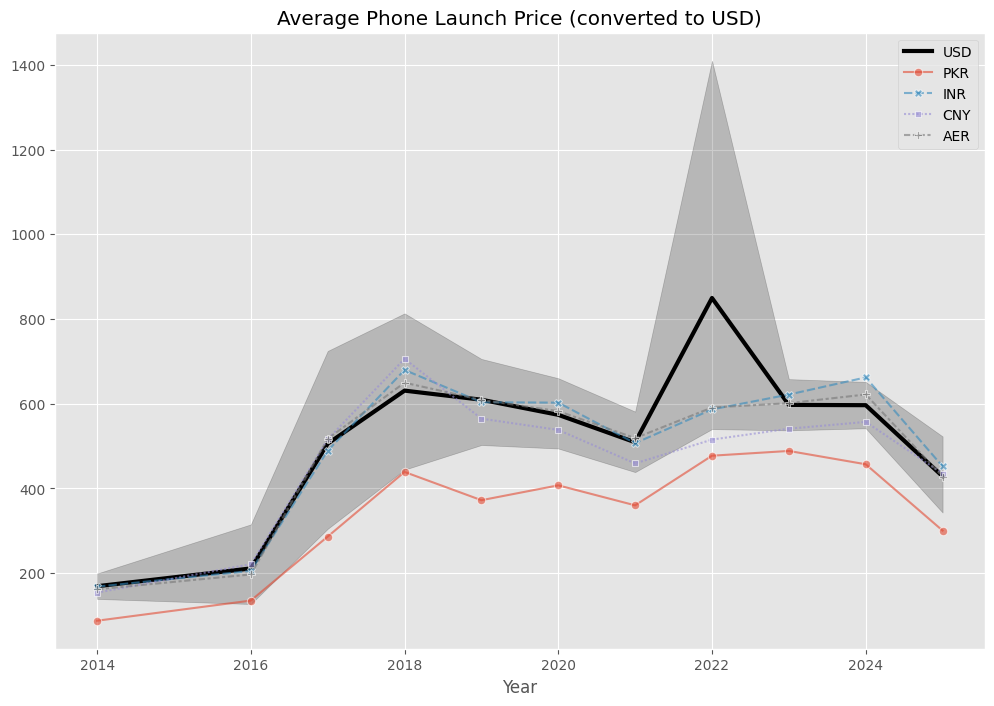

In [48]:
price_cols = [col for col in df.columns if col.endswith("to_usd")]
price_df = (df
            .filter(price_cols + ["launched_year"])
            .melt(
                id_vars=["launched_year"],       
                value_vars=price_cols,           
                var_name="currency_type",        
                value_name="price_usd"           
            )
)

plt.figure(figsize=(12,8))

sns.lineplot(
    data=price_df[price_df["currency_type"] == "usd_to_usd"],
    x="launched_year",
    y="price_usd",
    color="black",
    linewidth=3,      # thicker
    label="usd_to_usd"
)

sns.lineplot(
    data=price_df[price_df["currency_type"] != "usd_to_usd"],
    x="launched_year",
    y="price_usd",
    hue="currency_type",
    style="currency_type",
    err_style=None,
    markers=True,
    alpha=0.6         
)

plt.title("Average Phone Launch Price (converted to USD)")
plt.xlabel("Year")
plt.ylabel("")
plt.legend(title="Currency")
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(lbl) for lbl in ['usd_to_usd', 'pkr_to_usd', 'inr_to_usd', 'cny_to_usd', 'aed_to_usd']]
plt.legend([handles[i] for i in order], ['USD', 'PKR', 'INR', 'CNY', 'AER'])
plt.show()

It seems like all 5 prices follow similar trends with a price bump in 2022 in the US.

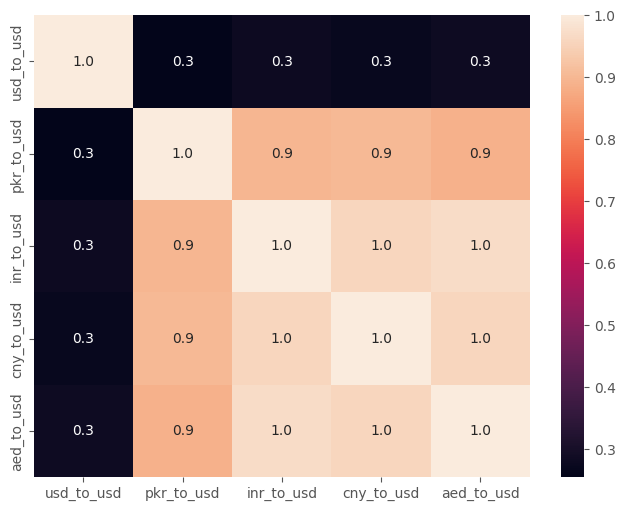

<Figure size 640x480 with 0 Axes>

In [49]:
price_correlation_df = (df
                       .filter([col for col in df.columns if col.endswith("to_usd")])
                       .corr()
)

plt.figure(figsize=(8,6))
sns.heatmap(price_correlation_df, annot=True, fmt=".1f")

plt.figure("Launched Price Correlation Between Regions")
plt.show()

The heatmap correlation plot also agrees with my statement previously. Then again, I won't be trusting this part of the analysis that much since we have a really small data and small number of launched phones before 2020.

## Phone Evolution

Understanding the types of smartphones available today is key to making smarter, more informed purchasing decisions. With so many options on the market, having insights into what you can realistically expect at different price points helps you shop wisely and get the most value for your money. 💸💸


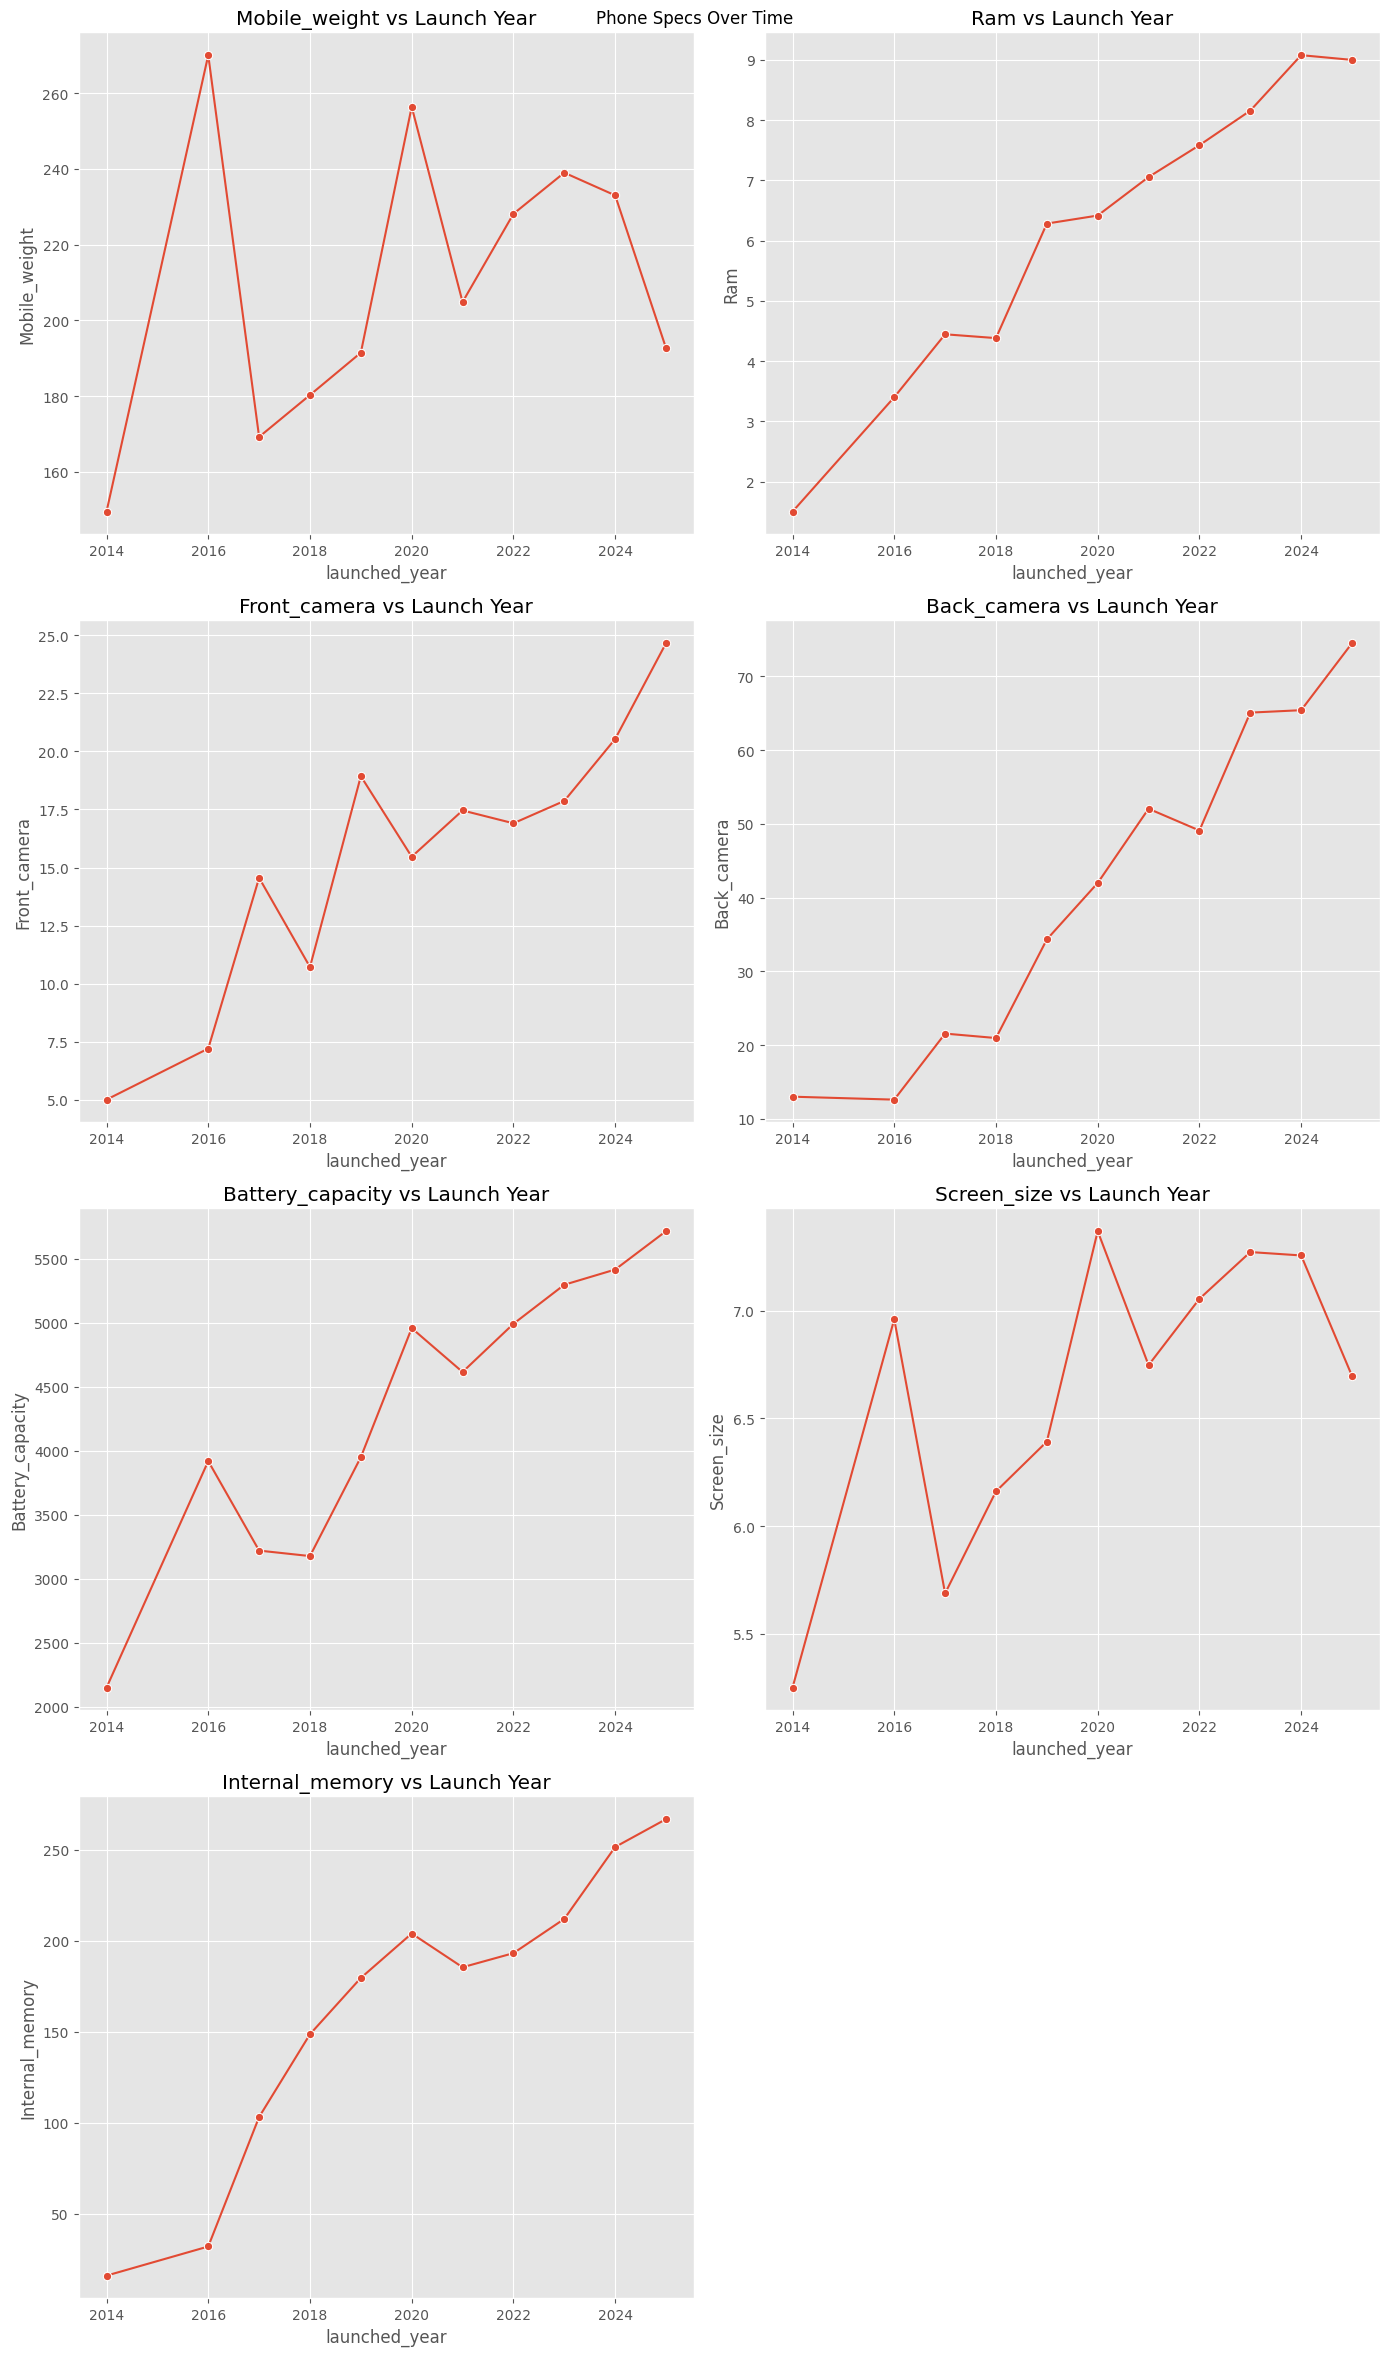

In [50]:
features = ["mobile_weight", "ram", "front_camera", "back_camera", "battery_capacity", "screen_size", "internal_memory"]
median_df = df.filter(["launched_year"] + features).groupby("launched_year").mean().reset_index()

n_features = len(features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.lineplot(data=median_df, x="launched_year", y=feature, ax=axes[i], marker="o")
    axes[i].set_title(f"{feature.capitalize()} vs Launch Year")
    axes[i].set_ylabel(feature.capitalize())
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Phone Specs Over Time')

plt.tight_layout()
plt.show()

It makes perfect sense that modern smartphones are getting larger yet somehow lighter thanks to bigger batteries needed to power increasingly powerful devices. At the same time, internal memory and RAM continue to grow, keeping up with the demands of heavy apps, multitasking, and high-end mobile gaming.

I still remember back in high school, I could run Instagram smoothly on a phone with just 2GB of RAM. Today, that same app would struggle without at least 6–8GB!

Another major shift? The focus on cameras. It feels like the market has flipped entirely. Today’s phones are less about calling and texting, and more about photography. You could even say we now carry cameras with phone capabilities, rather than phones with good cameras.

Oh, how the turns have tabled! 📸📱

## Value Phones

To identify the best phones for their price, we need to compare each device’s cost relative to its specifications. This value-for-money analysis allows us to see which phones offer high-end features at more affordable prices.

Comparing across brands and models takes this a step further revealing which companies consistently deliver better specs for the price. By identifying these high-value manufacturers, we can narrow our focus to their lineup and make smarter purchasing decisions based on performance, features, and overall value.

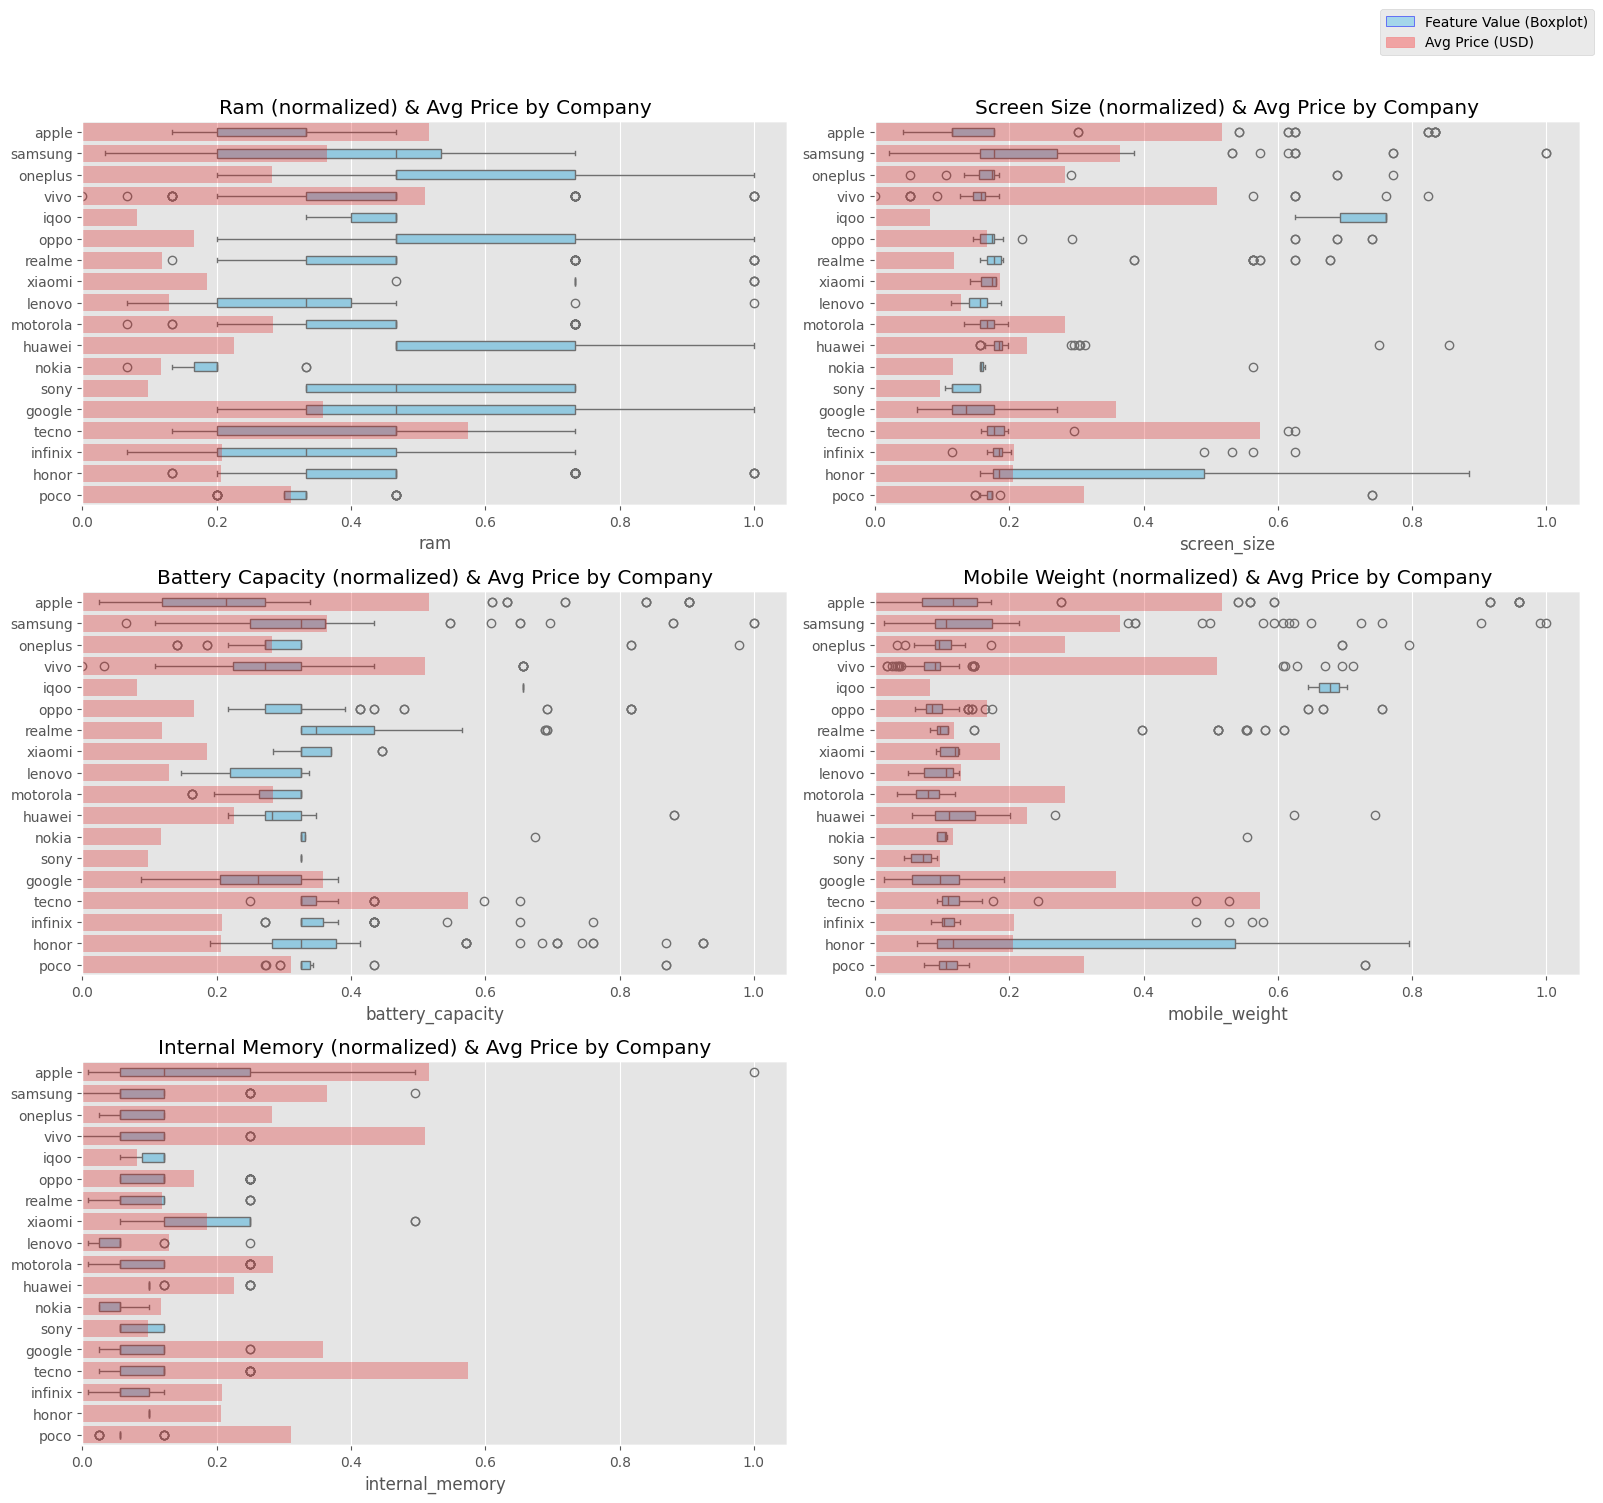

In [51]:
features = ["ram", "screen_size", "battery_capacity", "mobile_weight", "internal_memory"]
price_col = "launched_price_usa"

n_features = len(features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

scaler = MinMaxScaler()
numeric_features = features + [price_col]
series_comparison_df = usa_phones_df.copy()
series_comparison_df[numeric_features] = scaler.fit_transform(series_comparison_df[numeric_features])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows), sharey=False, sharex=False)
axes = axes.flatten()

legend_elements = [
    Patch(facecolor='skyblue', edgecolor='blue', alpha=0.7, label='Feature Value (Boxplot)'),
    Patch(facecolor='red', edgecolor='red', alpha=0.3, label='Avg Price (USD)')
]

for i, feature in enumerate(features):
    ax = axes[i]
    
    sns.boxplot(data=series_comparison_df, x=feature, y="company_name", ax=ax, color="skyblue", width=0.4)
    
    price_by_company = series_comparison_df.groupby("company_name")[price_col].mean().reset_index()

    # Draw the price barplot in the same subplot
    ax2 = ax.twinx()
    sns.barplot(data=price_by_company, y="company_name", x=price_col, ax=ax2, color="red", alpha=0.3)
    
    ax2.set_yticks([])
    ax2.set_ylabel(None)
    ax2.tick_params(right=False)

    ax.set_title(f"{feature.replace('_', ' ').title()} (normalized) & Avg Price by Company")
    ax.set_ylabel("")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add legend to the figure
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In many cases, Chinese brands such as *Huawei*, *OnePlus*, *Oppo*, *Realme*, and *Xiaomi* offer smartphones with specifications that match or even surpass those of competitors, yet at significantly lower price points. This highlights their strong value proposition in the global market.

To gain deeper insights, let’s segment the phones into meaningful groups based on their specifications and prices. Clustering analysis will help us identify natural groupings such as budget, mid-range, and flagship devices, making it easier to compare options within each category. We’ll use K-means clustering, combined with the Elbow Method and Silhouette Score, to determine the optimal number of clusters. This approach ensures that our segmentation is data-driven and well-justified, ultimately helping us pinpoint the best phones for each price segment.

In [52]:
features = ["ram", "screen_size", "battery_capacity", "mobile_weight", 
            "internal_memory", "front_camera", "back_camera", "launched_price_usa"]

cluster_df = usa_phones_df[features].dropna()

X = cluster_df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of k values to try
k_range = range(2, 10)

inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_) # For Elbow Method
    
    if k > 1:  # Silhouette score needs at least 2 clusters
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(None)

c:\Users\Archel\miniconda3\envs\data_viz\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\Archel\miniconda3\envs\data_viz\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Archel\miniconda3\envs\data_viz\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windo

Text(0, 0.5, 'Silhouette Score')

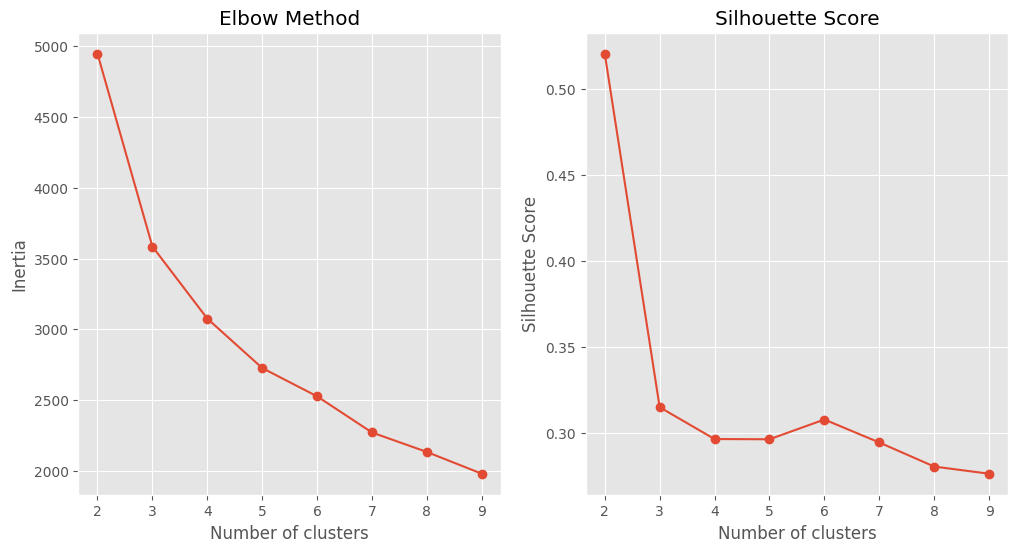

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(k_range, inertias, marker='o')
axes[0].set_title("Elbow Method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("Inertia")

axes[1].plot(k_range, silhouette_scores, marker='o')
axes[1].set_title("Silhouette Score")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Silhouette Score")

Both metrics suggest adding more clusters to yield better results. However, the best improvement was at `n=3` and so, we'll retrain the final K-means clustering model with 2 clusters instead.

c:\Users\Archel\miniconda3\envs\data_viz\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


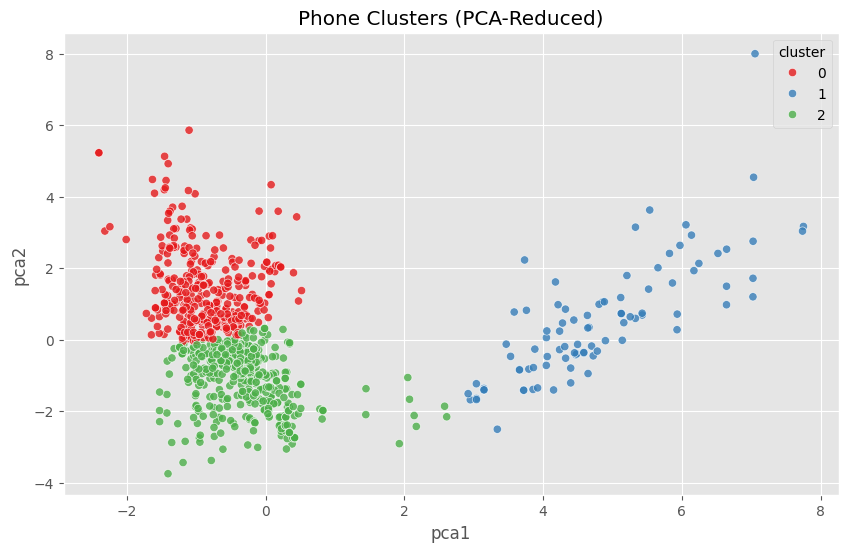

In [54]:
kmeans = KMeans(n_clusters=3, random_state=1)
cluster_df['cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cluster_df['pca1'] = X_pca[:, 0]
cluster_df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x='pca1', y='pca2', hue='cluster', palette='Set1', alpha=0.8)
plt.title("Phone Clusters (PCA-Reduced)")
plt.show()

In [55]:
# Transform back the scaled data to original values
cluster_df_original = pd.DataFrame(scaler.inverse_transform(X_scaled), columns=features)
cluster_df_original['knn_cluster'] = cluster_df['cluster']

# Show average values per cluster
cluster_summary = cluster_df_original.groupby('knn_cluster')[features].mean()
cluster_summary

,ram,screen_size,battery_capacity,mobile_weight,internal_memory,front_camera,back_camera,launched_price_usa
knn_cluster,,,,,,,,
0.0,9.646199,6.809503,4860.257310,205.525146,264.553706,24.084795,74.730994,709.915205
1.0,7.050000,10.431111,7659.377778,460.800000,214.783205,10.888889,27.222222,563.022222
2.0,6.631857,6.672658,4652.130802,202.408861,176.674802,15.398734,46.046414,500.683544


The cluster results don't seem that great. We can't see clearly the separation between cluster members.

If you like to watch phone reviews, most reviewers categorized phones into "Budget", "Mid-range", or "Flagship" categories depending on their prices and models. For example, the Samsung Galaxy S series lineup are considered "Flagship" while the A series are considered "Mid-range".

In our case, we can assign them manually using the price.

In [56]:
cluster_df_original["launched_price_usa"].describe()

count     918.000000
mean      581.977124
std       405.575432
min        99.000000
25%       249.250000
50%       449.000000
75%       849.000000
max      1899.000000
Name: launched_price_usa, dtype: float64

We can use the quantile values as our guide:

- \<$250: Budget
- \\$250 - \\$450: Mid-range
- \>\$450: Flagship

450 is too low in my opinion, let's try 600 instead

In [57]:
cluster_df_original["self_defined_cluster"] = pd.cut(
    cluster_df_original["launched_price_usa"],
    bins=[-np.inf, 250, 600, np.inf], # < 250: Budget, 250-600: Mid-range, > 600: Flagship
    labels=["Budget", "Mid", "Flagship"]
)

cluster_df_original.groupby('self_defined_cluster')[features].mean()

C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\3824435837.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_df_original.groupby('self_defined_cluster')[features].mean()


,ram,screen_size,battery_capacity,mobile_weight,internal_memory,front_camera,back_camera,launched_price_usa
self_defined_cluster,,,,,,,,
Budget,5.106838,6.882051,4977.970085,217.430769,125.513502,10.542735,37.696581,191.521368
Mid,8.067797,7.111864,5129.816384,223.301130,201.101942,22.926554,58.225989,410.991525
Flagship,9.396970,7.212818,4946.400000,242.609091,286.640804,18.421212,63.121212,1042.266667


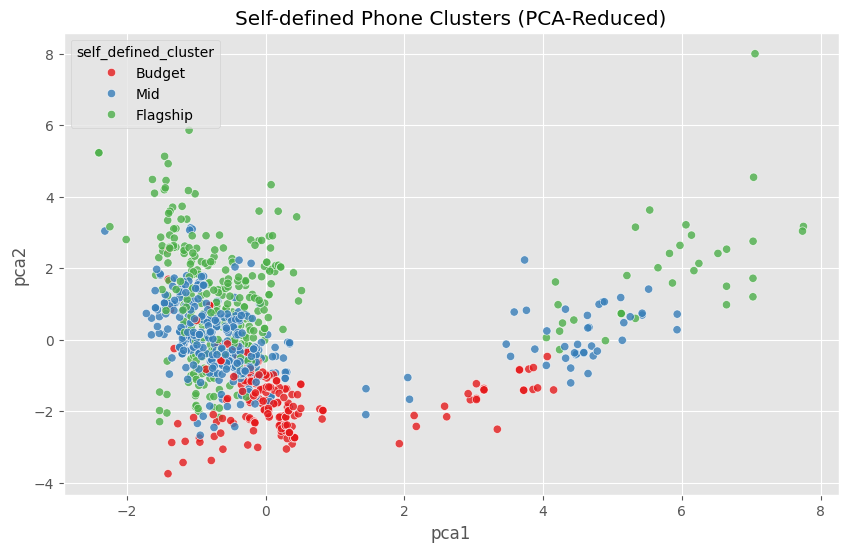

In [58]:
cluster_df_original['pca1'] = X_pca[:, 0]
cluster_df_original['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df_original, x='pca1', y='pca2', hue='self_defined_cluster', palette='Set1', alpha=0.8)
plt.title("Self-defined Phone Clusters (PCA-Reduced)")
plt.show()

In [59]:
cluster_df_original.groupby('self_defined_cluster')[features].mean()

C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\363744765.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_df_original.groupby('self_defined_cluster')[features].mean()


,ram,screen_size,battery_capacity,mobile_weight,internal_memory,front_camera,back_camera,launched_price_usa
self_defined_cluster,,,,,,,,
Budget,5.106838,6.882051,4977.970085,217.430769,125.513502,10.542735,37.696581,191.521368
Mid,8.067797,7.111864,5129.816384,223.301130,201.101942,22.926554,58.225989,410.991525
Flagship,9.396970,7.212818,4946.400000,242.609091,286.640804,18.421212,63.121212,1042.266667


This self-defined clustering approach works well, we’ll use it for the next steps of our analysis.

Now, to identify the "best value" phones , we can take several approaches. In my view and I suspect most people would agree, a "value" phone delivers strong specifications at a reasonable price. By "specs", we mean the key features we've discussed: RAM, internal memory, battery capacity, camera quality, screen size, and so on.

However, since these features are measured on different scales, using raw values directly could skew results. For example, internal storage (e.g., 128–512 GB) and battery capacity (e.g., 4000–6000 mAh) have much larger numerical ranges than, say, screen size or camera resolution, which might give them bigger influence in our analysis. To address this, we’ll scale the features, ensuring each contributes fairly to the final comparison.

Additionally, recall the heatmap showing correlations between features and price: RAM and internal memory showed the strongest positive relationships with price. This suggests they mainly drive both cost and perceived performance. Therefore, when calculating overall value, it makes sense to assign higher weights to RAM and internal memory, while giving relatively lower weights to other specs.

By combining scaled specifications with feature weighting based on their importance, we can create a more accurate and meaningful "value score" helping us objectively identify smartphones that truly offer the best bang for the buck.

$$
PriceToSpec Ratio = \frac{SpecScore}{Price}
$$

In [60]:
def calculate_spec_score(df):
    features = ["ram", "screen_size", "battery_capacity", "mobile_weight", "internal_memory", "front_camera", "back_camera", "launched_price_usa"]
    spec_df = df[features].copy()
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(spec_df)
    
    for i, col in enumerate(features):
        spec_df[f'{col}_scaled'] = features_scaled[:, i]

    # Try with different weight values!
    spec_df["spec_score"] = (
                            # Bigger weight values for internal memory and RAM
                            spec_df["internal_memory_scaled"] * 0.3 +
                            spec_df["ram_scaled"] * 0.3 +
                            # Smaller weight values for the rest
                            spec_df["screen_size_scaled"] * 0.08 +
                            spec_df["battery_capacity_scaled"] * 0.08 +
                            spec_df["mobile_weight_scaled"] * 0.08 +
                            spec_df["front_camera_scaled"] * 0.08 +
                            spec_df["back_camera_scaled"] * 0.08
    )

    spec_df['launched_price_usa_scaled'] = spec_df['launched_price_usa_scaled'].replace(0, 0.001)  # Avoid division by zero
    spec_df['value_ratio'] = spec_df['spec_score'] / spec_df['launched_price_usa_scaled']

    return spec_df

In [61]:
spec_df = calculate_spec_score(cluster_df_original)
spec_df = spec_df.join(usa_phones_df[["company_name", "model", "series"]], how='inner').join(cluster_df_original[["self_defined_cluster"]], how="inner")
spec_df['model_series'] = spec_df["company_name"] + " " + spec_df['model'] + ' ' + spec_df['series']
top_10 = spec_df.sort_values('value_ratio', ascending=False).head(10)
bottom_10 = spec_df.sort_values('value_ratio', ascending=True).head(10)

value_by_cluster = spec_df.pivot_table(index='model_series', columns='self_defined_cluster', values='value_ratio', fill_value=0)
top_10_pivot = top_10.pivot_table(index='model_series', columns='self_defined_cluster', values='value_ratio').head(10).sort_values(by=["Budget"])
bottom_10_pivot = bottom_10.pivot_table(index='model_series', columns='self_defined_cluster', values='value_ratio').head(10).sort_values(by=["Flagship"])

C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\2372322346.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  value_by_cluster = spec_df.pivot_table(index='model_series', columns='self_defined_cluster', values='value_ratio', fill_value=0)
C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\2372322346.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  top_10_pivot = top_10.pivot_table(index='model_series', columns='self_defined_cluster', values='value_ratio').head(10).sort_values(by=["Budget"])
C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\2372322346.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in 

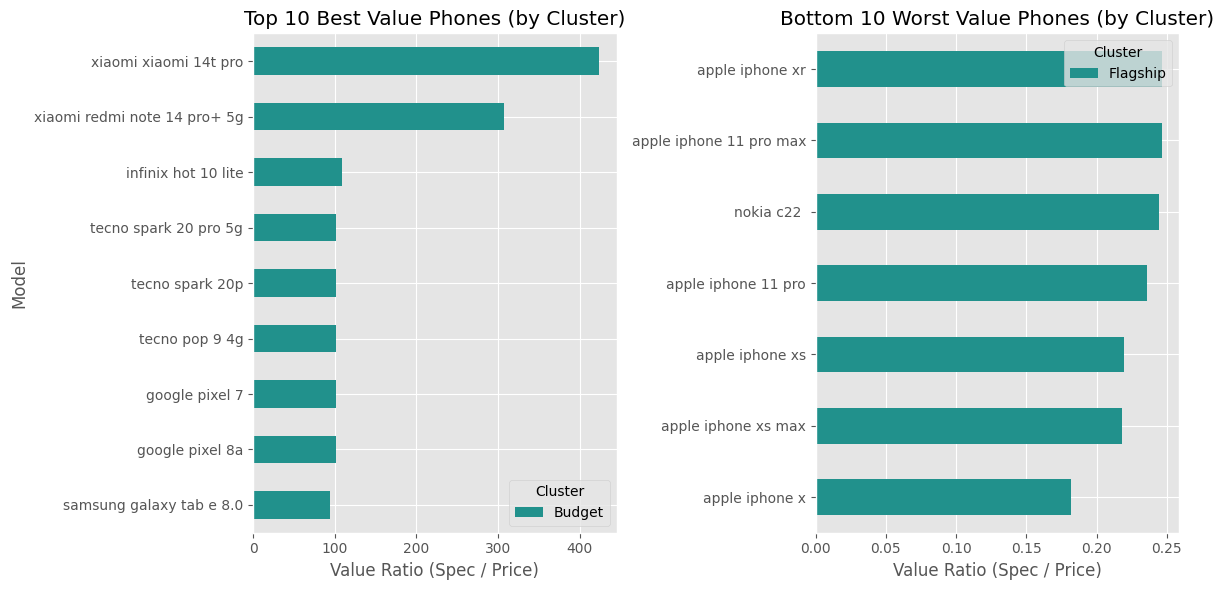

In [62]:
plt.figure(figsize=(12,6))

# Top 10
plt.subplot(1, 2, 1)
top_10_pivot.plot(kind='barh', stacked=True, ax=plt.gca(), color=sns.color_palette("viridis", len(top_10_pivot.columns)))
plt.title('Top 10 Best Value Phones (by Cluster)')
plt.xlabel('Value Ratio (Spec / Price)')
plt.ylabel('Model')
plt.legend(title='Cluster')

# Bottom 10
plt.subplot(1, 2, 2)
bottom_10_pivot.plot(kind='barh', stacked=True, ax=plt.gca(), color=sns.color_palette("viridis", len(bottom_10_pivot.columns)))
plt.title('Bottom 10 Worst Value Phones (by Cluster)')
plt.xlabel('Value Ratio (Spec / Price)')
plt.ylabel('')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

The top 10 best value phones are mostly dominated by the "Budget" cluster while the bottom 10 worst value phones are mostly dominated by "Flagship" (and iPhones, no hate tho✌️). To make it fair, we can show top 10 best values for all 3 clusters intead.

In [63]:
top_per_cluster = (
    spec_df
    .sort_values(['self_defined_cluster', 'value_ratio'], ascending=[True, False])
    .groupby('self_defined_cluster')
    .head(10)
)

top_per_cluster['model_series'] = top_per_cluster["company_name"] + " " + top_per_cluster['model'] + ' ' + top_per_cluster['series']

C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\3173028102.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('self_defined_cluster')


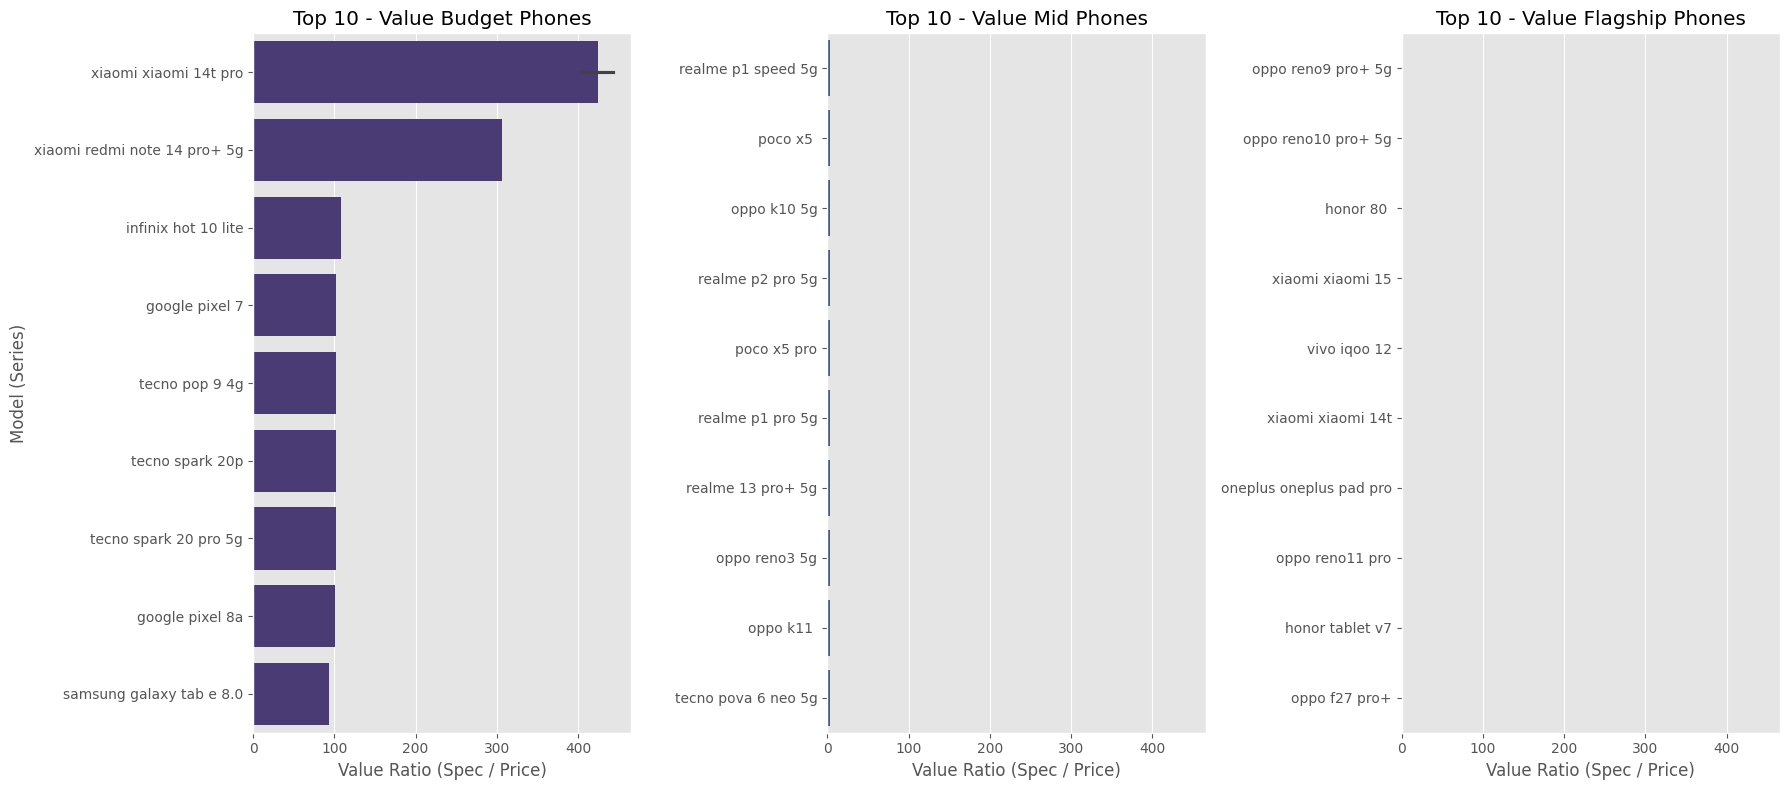

In [64]:
# Define clusters
clusters = ['Budget', 'Mid', 'Flagship']

# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharex=True)

for ax, cluster in zip(axes, clusters):
    # Filter data for cluster
    cluster_data = top_per_cluster[top_per_cluster['self_defined_cluster'] == cluster]
    
    # Plot
    sns.barplot(
        data=cluster_data,
        y='model_series', 
        x='value_ratio',
        ax=ax,
        color=sns.color_palette("viridis")[clusters.index(cluster)]
    )
    
    # Formatting
    ax.set_title(f'Top 10 - Value {cluster} Phones')
    ax.set_xlabel('Value Ratio (Spec / Price)')
    if clusters.index(cluster) == 0:
        ax.set_ylabel('Model (Series)')
    else:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [65]:
top_in_each_cluster = (
    spec_df
    .sort_values(['self_defined_cluster', 'value_ratio'], ascending=[True, False])
    .groupby('self_defined_cluster')
    .head(10)
    .reset_index()
)

columns_to_show = [
    'self_defined_cluster',
    'model',
    'series',
    'ram',
    'screen_size',
    'battery_capacity',
    'back_camera',
    'front_camera',
    'internal_memory',
    'launched_price_usa',
    'value_ratio'
]

top_specs_summary = (top_in_each_cluster
                     .filter(columns_to_show)
                     .rename(columns={
                            'self_defined_cluster': 'Cluster',
                            'model': 'Model',
                            'series': 'Series',
                            'ram': 'RAM (GB)',
                            'screen_size': 'Screen Size (inches)',
                            'battery_capacity': 'Battery (mAh)',
                            'back_camera': 'Rear Cam (MP)',
                            'front_camera': 'Front Cam (MP)',
                            'internal_memory': 'Storage (GB)',
                            'launched_price_usa': 'Price (USD)',
                            'value_ratio': 'Value Ratio'
                        })
)

C:\Users\Archel\AppData\Local\Temp\ipykernel_24652\1953339669.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('self_defined_cluster')


In [66]:
top_specs_summary.query("Cluster == 'Budget'")

,Cluster,Model,Series,RAM (GB),Screen Size (inches),Battery (mAh),Rear Cam (MP),Front Cam (MP),Storage (GB),Price (USD),Value Ratio
0,Budget,xiaomi,14t pro,12.0,6.67,5000.0,150.0,32.0,512.0,99.0,443.334722
1,Budget,xiaomi,14t pro,12.0,6.67,5000.0,150.0,32.0,256.0,99.0,404.625044
2,Budget,redmi,note 14 pro+ 5g,8.0,6.67,5110.0,210.0,16.0,128.0,99.0,306.852942
3,Budget,hot,10 lite,3.0,6.60,5000.0,13.0,8.0,64.0,99.0,108.400557
4,Budget,pixel,7,3.0,6.52,5000.0,8.0,5.0,64.0,99.0,101.761332
5,Budget,pop,9 4g,3.0,6.52,5000.0,8.0,5.0,64.0,99.0,101.761332
6,Budget,spark,20p,3.0,6.52,5000.0,8.0,5.0,64.0,99.0,101.761332
7,Budget,spark,20 pro 5g,3.0,6.52,5000.0,8.0,5.0,64.0,99.0,101.761332
8,Budget,pixel,8a,3.0,6.52,5000.0,8.0,5.0,64.0,99.0,101.091315
9,Budget,galaxy,tab e 8.0,1.5,8.00,5000.0,5.0,2.0,16.0,99.0,93.736500


In [67]:
top_specs_summary.query("Cluster == 'Mid'")

,Cluster,Model,Series,RAM (GB),Screen Size (inches),Battery (mAh),Rear Cam (MP),Front Cam (MP),Storage (GB),Price (USD),Value Ratio
10,Mid,p1,speed 5g,12.0,6.70,5100.0,66.0,16.0,256.0,270.0,3.671933
11,Mid,x5,,8.0,12.10,10000.0,8.0,8.0,128.0,280.0,3.539039
12,Mid,k10,5g,12.0,6.59,5000.0,74.0,16.0,256.0,279.0,3.527751
13,Mid,p2,pro 5g,16.0,6.78,5500.0,108.0,32.0,512.0,360.0,3.515760
14,Mid,x5,pro,8.0,12.10,10000.0,8.0,8.0,256.0,300.0,3.360223
15,Mid,p1,pro 5g,12.0,6.70,5200.0,66.0,16.0,256.0,290.0,3.301946
16,Mid,13,pro+ 5g,16.0,6.78,5500.0,108.0,32.0,512.0,380.0,3.271536
17,Mid,reno3,5g,12.0,6.40,4025.0,76.0,32.0,256.0,299.0,3.257588
18,Mid,k11,,12.0,6.70,5000.0,74.0,16.0,256.0,299.0,3.157899
19,Mid,pova,6 neo 5g,8.0,6.80,5200.0,50.0,32.0,256.0,269.0,3.065149


In [68]:
top_specs_summary.query("Cluster == 'Flagship'")

,Cluster,Model,Series,RAM (GB),Screen Size (inches),Battery (mAh),Rear Cam (MP),Front Cam (MP),Storage (GB),Price (USD),Value Ratio
20,Flagship,reno9,pro+ 5g,16.0,6.70,4700.0,60.0,32.0,256.000000,649.0,1.458663
21,Flagship,reno10,pro+ 5g,16.0,6.74,4700.0,122.0,32.0,256.000000,699.0,1.409769
22,Flagship,80,,12.0,6.78,5000.0,200.0,50.0,212.524422,699.0,1.320432
23,Flagship,xiaomi,15,16.0,6.36,5400.0,100.0,32.0,512.000000,799.0,1.292492
24,Flagship,iqoo,12,16.0,6.78,5000.0,50.0,16.0,256.000000,699.0,1.277657
25,Flagship,xiaomi,14t,12.0,6.67,5000.0,100.0,32.0,512.000000,699.0,1.267233
26,Flagship,oneplus,pad pro,12.0,12.40,11000.0,50.0,16.0,212.524422,799.0,1.264938
27,Flagship,reno11,pro,12.0,6.74,4600.0,90.0,32.0,512.000000,699.0,1.245110
28,Flagship,tablet,v7,16.0,13.20,10500.0,16.0,12.0,212.524422,899.0,1.241646
29,Flagship,f27,pro+,12.0,6.70,5000.0,66.0,32.0,512.000000,699.0,1.221890


And there you have it! 🎉

Next time you or someone you know is looking to buy a new phone, just come back to this notebook. 😊

Fun fact: after showing this analysis to my mom, she actually bought a Xiaomi 14C! It wasn’t exactly the same model as one of the top-ranked budget value phones we found, but it was very close and clearly aligned with the insights from our analysis. This whole process saved us hours of scrolling through reviews and comparing specs manually.

Thank you so much for reading through my first public notebook on Kaggle! I hope you found it helpful and insightful.

Feel free to copy, edit, and build upon it. I’d love to see how you use it in your own decision-making. Happy analyzing! 🤗📊